In [2]:
#| default_exp mplots   

# Mplots

This notebook is used for implementing basic dataclasses and functions for better integration of Matrix Profile and MPlots into deepVATS as an efficient tool for discovering boths patterns and anomalies in Large Time Series. 

This tool is introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)


## Libraries

In [3]:
#| export
## -- Deepvats
import dvats.load as load
import dvats.memory as mem
import dvats.utils as ut

In [4]:
#| hide
## -- Ñapa por si tienes problemas de memoria en el current device -- ##
## De normal debe estar comentado
import torch
torch. cuda.set_device(0)
## -- Hasta aquí la ñapa -- ##

In [5]:
#| export
## -- Matrix profile
import pyscamp as scamp
import stumpy as stump 
from stumpy import config as stump_cfg
## -- Utilities
import os
import numpy as np
import pandas as pd
import datetime as dt
import math
import warnings

from aeon.segmentation._clasp import ClaSPSegmenter, find_dominant_window_sizes
from aeon.datasets import load_electric_devices_segmentation
from aeon.visualisation import plot_series_with_change_points, plot_series_with_profiles

## -- Classes & types
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Callable
## -- Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from mpl_toolkits.axes_grid1 import ImageGrid

## -- Interactive Plots
import ipywidgets as widgets
from IPython.display import display, clear_output


from copy import deepcopy
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

from concurrent.futures import ThreadPoolExecutor

#-- Generic
import sys



In [6]:
#| export
#-- "Importing" MPlots MATLAB code
import oct2py

def configure_octave():
    try:
        oc = oct2py.Oct2Py()
        oc.eval("graphics_toolkit('fltk')")
        return oc
    except oct2py.Oct2PyError as e:
        print(f"Oct2PyError: {e}")
octave = configure_octave()

if octave:
    print("Octave is ready", octave)
    mplot_path = os.path.expanduser('~/work/nbs/mplot')
    octave.addpath(mplot_path);
    octave.chdir(mplot_path);
    #%load_ext oct2py.ipython
    octave.register_graphics_toolkit('fltk')
    octave.graphics_toolkit('fltk')
    octave.set(0, 'defaultfigurevisible', 'on');
else:
    print("Octave is not ready. Please check the configuration | ", octave)


Octave is ready <oct2py.core.Oct2Py object at 0x7f7a92139210>

















In [7]:
#| hide 
octave.eval("hello_world")
octave.source("hello_world.m")




Hello world



Hello world


## Utilities

### Distance Functions

#### Comparing sequences
##### Euclidean distance

To compare two subsequences **with the same length** we can use, for example, the Euclidean distance:

$ d(TA, \, TB) = \sqrt{\sum_{i=0}^{n} (TA_{i}-TB_{i})^2} $

In [8]:
#| export
def euclidean_distance (
    vector_a    : List [ float ],
    vector_b    : List [ float ],
    print_flag  : bool = False,
    time_flag   : bool = False,
    print_depth : int  = 1
) -> Tuple[float, Optional[ ut.Time ]]:
    """
    Calculates the Euclidean distance between two vectors.

    Args:
        vector_a: First vector as a list of floats.
        vector_b: Second vector as a list of floats.
        print_flag: If True, prints the vectors.
        time_flag: If True, measures and displays the time taken by the function.

    Returns:
        A tuple containing the distance and an object of Time if time_flag is True, or None otherwise.
    """
    t = None 
    #if print_flag: print("--> Ensuring the vectors are numpy arrays")
    vector_a = np.array(vector_a)
    vector_b = np.array(vector_b)
    if print_flag and print_depth > 0: 
        print("va", vector_a)
        print("vb", vector_b)
    if time_flag:
        t = ut.Time(function = ut.funcname())
        t.start(print_flag = print_flag and print_depth > 1)
    dist = np.linalg.norm(vector_a - vector_b)
    if time_flag: 
        t.end(print_flag = print_flag and print_depth > 1)
        if print_flag and print_depth > 0: t.show()
    return dist, t

In [9]:
#| hide
foo = euclidean_distance(
    vector_a = [0,1,3,2], 
    vector_b = [1, 2, 2, 10],
    print_flag = True,
    time_flag = True
)
foo

va [0 1 3 2]
vb [ 1  2  2 10]
[euclidean_distance] Start: 1719497462.4004307 | End: 1719497462.4072006 | Duration: 0.006769895553588867 seconds


(8.18535277187245,
 Time(time_start=1719497462.4004307, time_end=1719497462.4072006, time_total=0.006769895553588867, function='euclidean_distance'))

##### Other distances
###### Z-normalized euclidean distance
One of the most used distances in the analysis of TS via MPlots is the z-euclidean distance.
Defined as: 

$zn\_euclidean\_distance(a,b) = euclidean\_distance(zn(a), zn(b))$

with zn being the z-normalization 

$zn(\vec{x}) = \frac{\vec{x}-\mu_x}{\sigma_x} = (x-mean(x))/std(x,1) $

In [10]:
#| export
def z_normalize(
    sequence    : List [ float ],
    print_flag  : bool = False,
    time_flag   : bool = False,
    print_depth : int  = 1
) -> Tuple[ List[ float ], Optional[ ut.Time ] ]:
    t = None
    if time_flag:
        t = ut.Time(function=ut.funcname())
        t.start(print_flag and print_depth > 1)
    
    mean    = np.mean(sequence)
    std     = np.std(sequence)
    res     = (sequence - mean) / std
    
    if time_flag: 
        t.end(print_flag and print_depth > 1)
        if print_flag and print_depth > 0: t.show()
    return res, t

In [11]:
#| hide
foo = [14, 9, 24, 39, 60]
z_normalize(foo, time_flag = True)

(array([-0.82172967, -1.09203549, -0.28111805,  0.52979939,  1.66508381]),
 Time(time_start=1719497462.4810073, time_end=1719497462.4814062, time_total=0.00039887428283691406, function='z_normalize'))

In [12]:
#| export
def z_normalized_euclidean_distance(
    vector_a    : List [ float ],
    vector_b    : List [ float ],
    print_flag  : bool = False,
    time_flag   : bool = False,
    inside_times: bool = False,
    print_depth : int  = 1
) -> Tuple[ List [ float ], Optional[ ut.Time ], Optional [ List [ ut.Time ] ] ]:
    t = None
    ts = [ None, None, None ]
    if print_flag and print_depth > 0: 
        print("va", vector_a)
        print("vb", vector_b)

    if time_flag:
        t = ut.Time( function = ut.funcname() )
        t.start(print_flag)
    
    #-- Normalize
    vector_a, ts[0] = z_normalize(vector_a, time_flag = inside_times)
    vector_b, ts[1] = z_normalize(vector_b, time_flag = inside_times)   

    #-- Compute distance
    res, ts[2] = euclidean_distance(vector_a, vector_b, time_flag = inside_times)
    
    if time_flag:
        t.end(print_flag)
        if print_flag: t.show()
    if print_flag and print_depth > 0: 
        print("zn-va", vector_a)
        print("zn-vb", vector_b)
        print("dist", res)
    return res, t, ts

In [13]:
#| hide
foo_a = [8.5, 9.2]
foo_b = [7.3, 8.1]
euclidean_distance(
    vector_a = foo_a, 
    vector_b = foo_b,
    print_flag = True,
    time_flag = True
)
z_normalized_euclidean_distance(
    vector_a = foo_a, 
    vector_b = foo_b,
    print_flag = True,
    time_flag = True
)


va [8.5 9.2]
vb [7.3 8.1]
[euclidean_distance] Start: 1719497462.554145 | End: 1719497462.5542188 | Duration: 7.367134094238281e-05 seconds
va [8.5, 9.2]
vb [7.3, 8.1]
--> Start:  z_normalized_euclidean_distance
End:  z_normalized_euclidean_distance -->
[z_normalized_euclidean_distance] Start: 1719497462.588121 | End: 1719497462.5884707 | Duration: 0.0003497600555419922 seconds
zn-va [-1.  1.]
zn-vb [-1.  1.]
dist 1.5700924586837751e-15


(1.5700924586837751e-15,
 Time(time_start=1719497462.588121, time_end=1719497462.5884707, time_total=0.0003497600555419922, function='z_normalized_euclidean_distance'),
 [None, None, None])

### Time Series / Sequences show & plot

In [14]:
#| export
def show_sequence(
    data         : List[ List [ float ] ] = None, 
    hide_rows    : bool = False, 
    hide_columns : bool = True
):
    """
    Show the sequence in a nice format similar to stumpy tutorials
    """
    df          = pd.DataFrame(data)
    styled_df   = df.style
    if hide_rows: 
        styled_df = styled_df.hide(axis='index')
    if hide_columns: 
        styled_df = styled_df.hide(axis='columns')
    styled_df = styled_df.set_table_styles([
        {'selector': '',
         'props': [('border', '2px solid black'),
                   ('text-align', 'center'),
                   ('font-family', 'Arial'),
                   ('border-collapse', 'collapse')]},
        {'selector': 'td',
         'props': [('border', '1px solid black'),
                   ('padding', '5px')]}
    ])
    display(styled_df)

In [15]:
#| hide
foo_data = np.array([[0, 1, 3, 2, 9, 1, 14, 15, 1, 2, 2, 10, 7]])
show_sequence(foo_data, True, False)

0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,3,2,9,1,14,15,1,2,2,10,7


In [16]:
#| export
def plot_with_dots(
    time_series             : List [ float ]    = None,
    xlabel                  : str               = 'Index (time)',
    ylabel                  : str               = 'Value',
    title                   : str               = 'Time series',
    sequence_flag           : bool              = True,
    show_sequence_before    : bool              = True, 
    hide_rows               : bool              = True,
    hide_columns            : bool              = False,
    show_title              : bool              = True   
  ) -> None:
    if sequence_flag and show_sequence_before: 
        show_sequence([time_series], hide_rows, hide_columns)
    n = len(time_series)
    x_coords = range(n)
    plt.plot(x_coords, time_series)
    plt.scatter(x_coords, time_series, color='red')
    if show_title: plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    if sequence_flag and not show_sequence_before: show_sequence([time_series], hide_rows, hide_columns)
    return None



0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,3,2,9,1,14,15,1,2,2,10,7


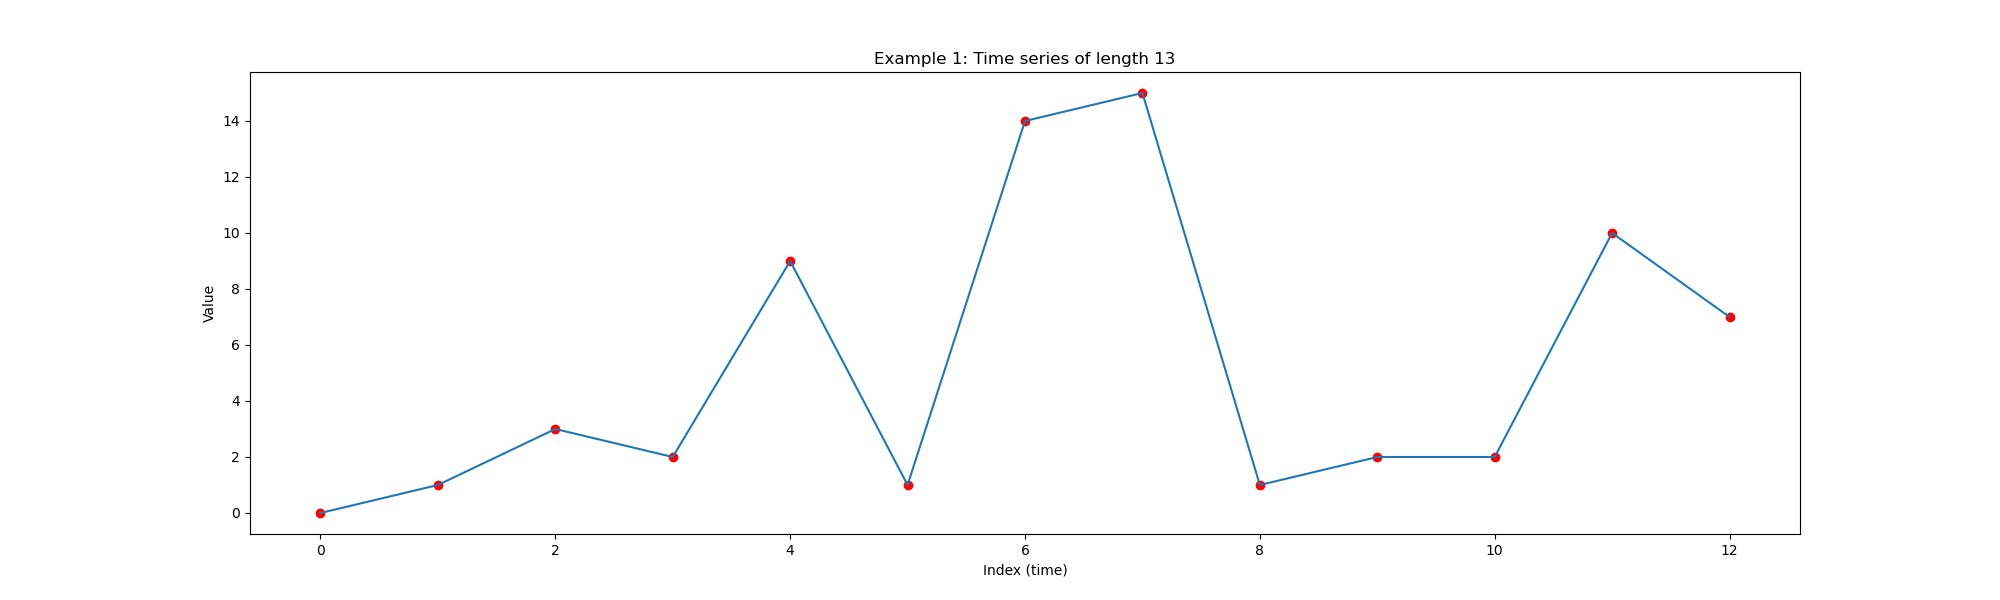

In [17]:
#| hide
# Example following Stumpy's 13-length case
foo_data = np.array([0, 1, 3, 2, 9, 1, 14, 15, 1, 2, 2, 10, 7])
foo_title = title = "Example 1: Time series of length 13"
show_sequence([foo_data], hide_rows = True, hide_columns = False)
plot_with_dots(
    time_series             = foo_data,
    title                   = foo_title,
    sequence_flag           = False
) 

#### Subsequences show & plot
Subsequence: 

$ T^{(i,m)} = \{T_k\}_{k=i}^m = T_i,\, \ldots, \, T_{i+m} \; i, m \in \mathbb{Z}_{\geq 0} $

In [18]:
#| export
def show_subsequence(
        data         : List [ float ], 
        i            : int  = 0, 
        m            : int  = 1, 
        hide_rows    : bool = False, 
        hide_columns : bool = True, 
    ):
        """ Show the subsequence in a nice format similar to stumpy tutorials"""
        show_sequence(
                data            = [data[i:m]],
                hide_rows       = hide_rows, 
                hide_columns    = hide_columns, 
        )

In [19]:
#| hide
show_subsequence(foo_data, 0, 3, True, False)

0,1,2
0,1,3


In [20]:
#| export
def plot_subsequence(
    TA              : List [ float ]    = None,
    sequence_i      : int               = 0,
    subsequence_len : int               = 1,
    color           : str               = 'green',
    dots            : bool              = True,
    dots_color      : str               = 'red',
    label           : bool              = False,
    sequence_flag   : bool              = True,
    hide_rows       : bool              = True,
    hide_columns    : bool              = False,
    print_flag      : bool              = False,
    save_plot       : bool              = False
) -> None:

    n = len(TA)
    x_coords = range(n)


    fig_height_in = 0.59  + 2
    fig, axs = plt.subplots(1, 1, figsize=(12, fig_height_in), sharex=True)


    axs.plot(x_coords, TA, label='TA')
    i = sequence_i
    axs.plot(
        x_coords[i:i+subsequence_len], TA[i:i+subsequence_len],
        color=color,
        label='Subsequence' if i == 0 else ""
      )
    axs.legend()
    #axs.set_title('Subsequence_' + str(i) +"_"+str(subsequence_len))
    axs.set_title('Subsequence_' + str(i) +"_"+str(subsequence_len), fontsize=20)
    if dots:
      plt.scatter(x_coords, TA, color=dots_color)
      if label:
        subsequence_x = x_coords[sequence_i:sequence_i + subsequence_len]
        subsequence_y = TA[sequence_i:sequence_i + subsequence_len]
        for x, y in zip(subsequence_x, subsequence_y):
            axs.text(x, y+0.3, f'{y:.2f}', color=dots_color, fontsize=8, ha='center', va='bottom')  # Añade el valor sobre el punto
    plt.tight_layout()
    plt.savefig('subsequence_'+str(i) + "_"+str(subsequence_len)+'.png')
    plt.show()
    if sequence_flag : show_sequence([TA[sequence_i:sequence_i + subsequence_len]], hide_rows, hide_columns)

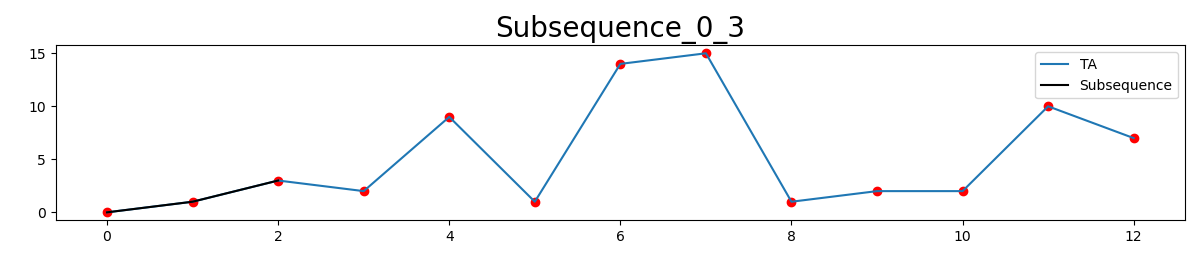

0,1,2
0,1,3


In [21]:
#| hide
plot_subsequence(
    TA              = foo_data,
    sequence_i      = 0,
    subsequence_len = 3,
    color           = 'black',
    dots            = True,
    dots_color      = 'red',
    label           = False,
    sequence_flag   = True,
    hide_rows       = True,
    hide_columns    = False,
    print_flag      = False,
    save_plot       = True
)

#### Matlab & Google Drive matrix load

> Eamonn usually saves public examples data in Google Drive as matlab matrices
> 
> This part of the code is for directly downloading such data from the jupyter notebook 

In [22]:
#| export
class GD_Mat:
    def __init__(self, id,  name, data_path = '~/data'):
        self.id                 = id #GD id
        self.data_path          = os.path.expanduser(data_path) # Local data path
        self.zip_path           = os.path.join(self.data_path, name + '.zip')
        self.mat_path           = os.path.join(self.data_path, name + '.mat')
        self.mats_files         = None
        self.mats               = None #Downloaded matlab matrices
        self.mats_df            = None
        self.num_mats           = 0
        self.num_mats_extracted = 0
        
    def download_file_from_google_drive(self):
        return load.download_file_from_google_drive(self.id, self.zip_path)
        
    def get_mat_files(self):
        self.mats_files = [f for f in load.zip_contents(self.zip_path) if not f.startswith('__MACOSX/')]
        self.num_mats = len(self.mats_files)
        self.mats = self.mats_df = [None]*self.num_mats
    
    def unzip_mat(self, all_one, case = '', print_flag = False): 
        str = load.unzip_mat(all_one, self.zip_path, self.data_path, case, print_flag)
        self.get_mat_files()
        return str
        
    def mat2csv(self, case_id, print_flag = False):
        if print_flag: print("--> mat2csv", case_id)
        case = self.mats_files[case_id]
        case_path = os.path.join(self.data_path, case)
        print("Mat2csv case", case_path)
        self.mats_df[case_id] = load.mat2csv(case_path, self.data_path, print_flag)
        if print_flag: print("mat2csv", case_id, "-->")
        
    def __str__(self): 
        str = f"FileID: {self.id}\nData path: {self.data_path}\n"
        str += f"zip path: {self.zip_path}\nmat_files: {self.mats_files}"
        str +=f"\nnum_mats: {self.num_mats}"
        return str

In [23]:
#| export
@dataclass
class MatlabMatrix: 
    #File name
    filename : str = ""
    #Matrix name
    matname : str = ""
    #1-D numpy array with the time serie data
    data : List [ float ] = None
    #Length used for smoothing the time serie (if smoothed)
    smoothing_window_len : int = None
    #Wether if it has been smoothed yet or not 
    smoothed : bool = False
    path : str = None
    
    def load(
        self, 
        #Col in the matrix containing the time serie
        numcol      : int, 
        #Wether to print messages for debugging or not
        print_flag  : bool  = False,
        force_smooth: bool  = False,
        path        : str   = ".",
        print_depth : int   = 1
    ) -> List [ float ] : 
        """ Reads the file and load the column numcol of the matrix as time series data. """
        
        if self.path is None:
            path = path

        dir = self.path + '/' + self.filename  + ".mat"
        
        dict = octave.load(dir)
        data = dict[self.matname]
        
        if print_flag and print_depth > 0: print(data.dtype)
        
        self.data = np.array(data[:,numcol])
        
        return self.data

    def smooth(
        self, 
        window_len  : int   = 11, 
        print_flag  : bool  = False,
        force_smooth: bool  = False,
        print_depth : int   = 1
    ) -> List [ float ]:
        """ Applies moving average for smoothing the time serie data. """
        # window_len: smoothing window size needs, which must be odd number,
        
        if ( ( not self.smoothed ) or force_smooth ) :
            self.smoothed = True
        
            # Step 1: Apply the moving average to the main part of the data using convolution
        
            self.smoothing_window_len = window_len
        
            if self.smoothing_window_len % 2 == 0:
                warnings.warn("Window len must be odd! Adding 1 to your length.")
                self.smoothing_window_len += 1
            
            if print_flag and print_depth > 0: print("---> About to get out0")
            
            out0 = np.convolve(
                self.data, 
                np.ones(self.smoothing_window_len, dtype=int),
                'valid'
            ) / self.smoothing_window_len
        
            # Step 2: Handle the beginning of the array (start)
            # Use cumulative sum and then average it by the increasing window size
        
            if print_flag : 
                print("out0 ~", out0.shape)
                print("---> About to get start")
        
            r = np.arange(1, self.smoothing_window_len-1, 2)
        
            if print_flag: print("r", r)
        
            start = np.cumsum(self.data[:self.smoothing_window_len-1])[::2] / r
        
            if print_flag:
                print("start", start)
                print("---> About to get stop")
        
            # Step 3: Handle the end of the array (stop)
            # Reverse the array, use cumulative sum, and then average it by the increasing window size
        
            stop = (np.cumsum(self.data[:-self.smoothing_window_len:-1])[::2] / r)[::-1]
    
            if print_flag: 
                print("stop", stop)
        
            # Step 4: Combine the start, middle, and end parts together
            self.data = np.concatenate((start, out0, stop))
            return self.data

In [24]:
#| hide
foo = os.path.expanduser('~/work/nbs_pipeline/octave-tests')
#print(foo)
! ls {foo}
foo = MatlabMatrix(
    filename = 'MP_first_test_penguin_sample', 
    matname = 'penguin_sample',
    path = foo
)
foo.load( numcol = 0, print_flag = True )
print(foo.data.shape)

MP_first_test_penguin_sample.mat  hola_mundo.m	interactiveMatrixProfileVer3.m



float64
(109842,)


In [25]:
#| hide Exoplanets
file_id = '1Li9D5YyspA6eQtpGRihOi0y9D85cq4GE'
name = 'exoDataFig1'
gd_mat = GD_Mat(file_id, name)
print(gd_mat)
gd_mat.download_file_from_google_drive()
print(gd_mat)
gd_mat.unzip_mat('all')
print(gd_mat)
gd_mat.mat2csv(0)
print(gd_mat)
display(gd_mat.mats_df[0].head(5))

FileID: 1Li9D5YyspA6eQtpGRihOi0y9D85cq4GE
Data path: /home/macu/data
zip path: /home/macu/data/exoDataFig1.zip
mat_files: None
num_mats: 0
Failed to download the zip file. The link may require additional permissions or the ID may be incorrect.
FileID: 1Li9D5YyspA6eQtpGRihOi0y9D85cq4GE
Data path: /home/macu/data
zip path: /home/macu/data/exoDataFig1.zip
mat_files: None
num_mats: 0


BadZipFile: File is not a zip file

In [26]:
#| hide 
file_id = '1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ'
name = 'InsectData-fig11'

gd_mat = GD_Mat(file_id, name)
print(gd_mat)
gd_mat.unzip_mat('all')
print(gd_mat)
gd_mat.mat2csv(0)
print(gd_mat)
display(gd_mat.mats_df[0].head(5))

FileID: 1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ
Data path: /home/macu/data
zip path: /home/macu/data/InsectData-fig11.zip
mat_files: None
num_mats: 0
FileID: 1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ
Data path: /home/macu/data
zip path: /home/macu/data/InsectData-fig11.zip
mat_files: ['Insect_one_million.mat']
num_mats: 1
Mat2csv case /home/macu/data/Insect_one_million.mat
FileID: 1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ
Data path: /home/macu/data
zip path: /home/macu/data/InsectData-fig11.zip
mat_files: ['Insect_one_million.mat']
num_mats: 1


,Insect_one_million
0,0.236820
1,0.236820
2,0.238040
3,0.206300
4,0.026855


### Automatic sequence length selection

#### Following ClaSP example: best sequence length
In a similar way to ClaSP algorithm, our algorithms take the window size, w as hyper-parameter (see https://github.com/aeon-toolkit/aeon/blob/main/examples/segmentation/segmentation_with_clasp.ipynb). A simple method for choosing the window size is the dominant frequency of the Fourier Transform.

In [27]:
#| hide
? aeon.segmentation._clasp.find_dominant_window_sizes

Object ` aeon.segmentation._clasp.find_dominant_window_sizes` not found.


Dominant Period 10


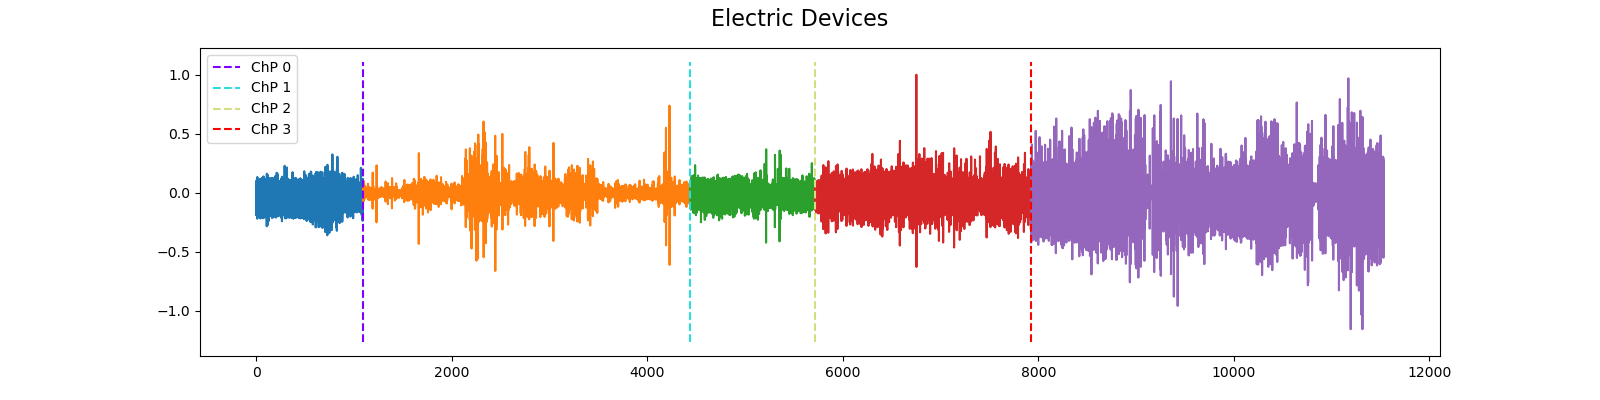

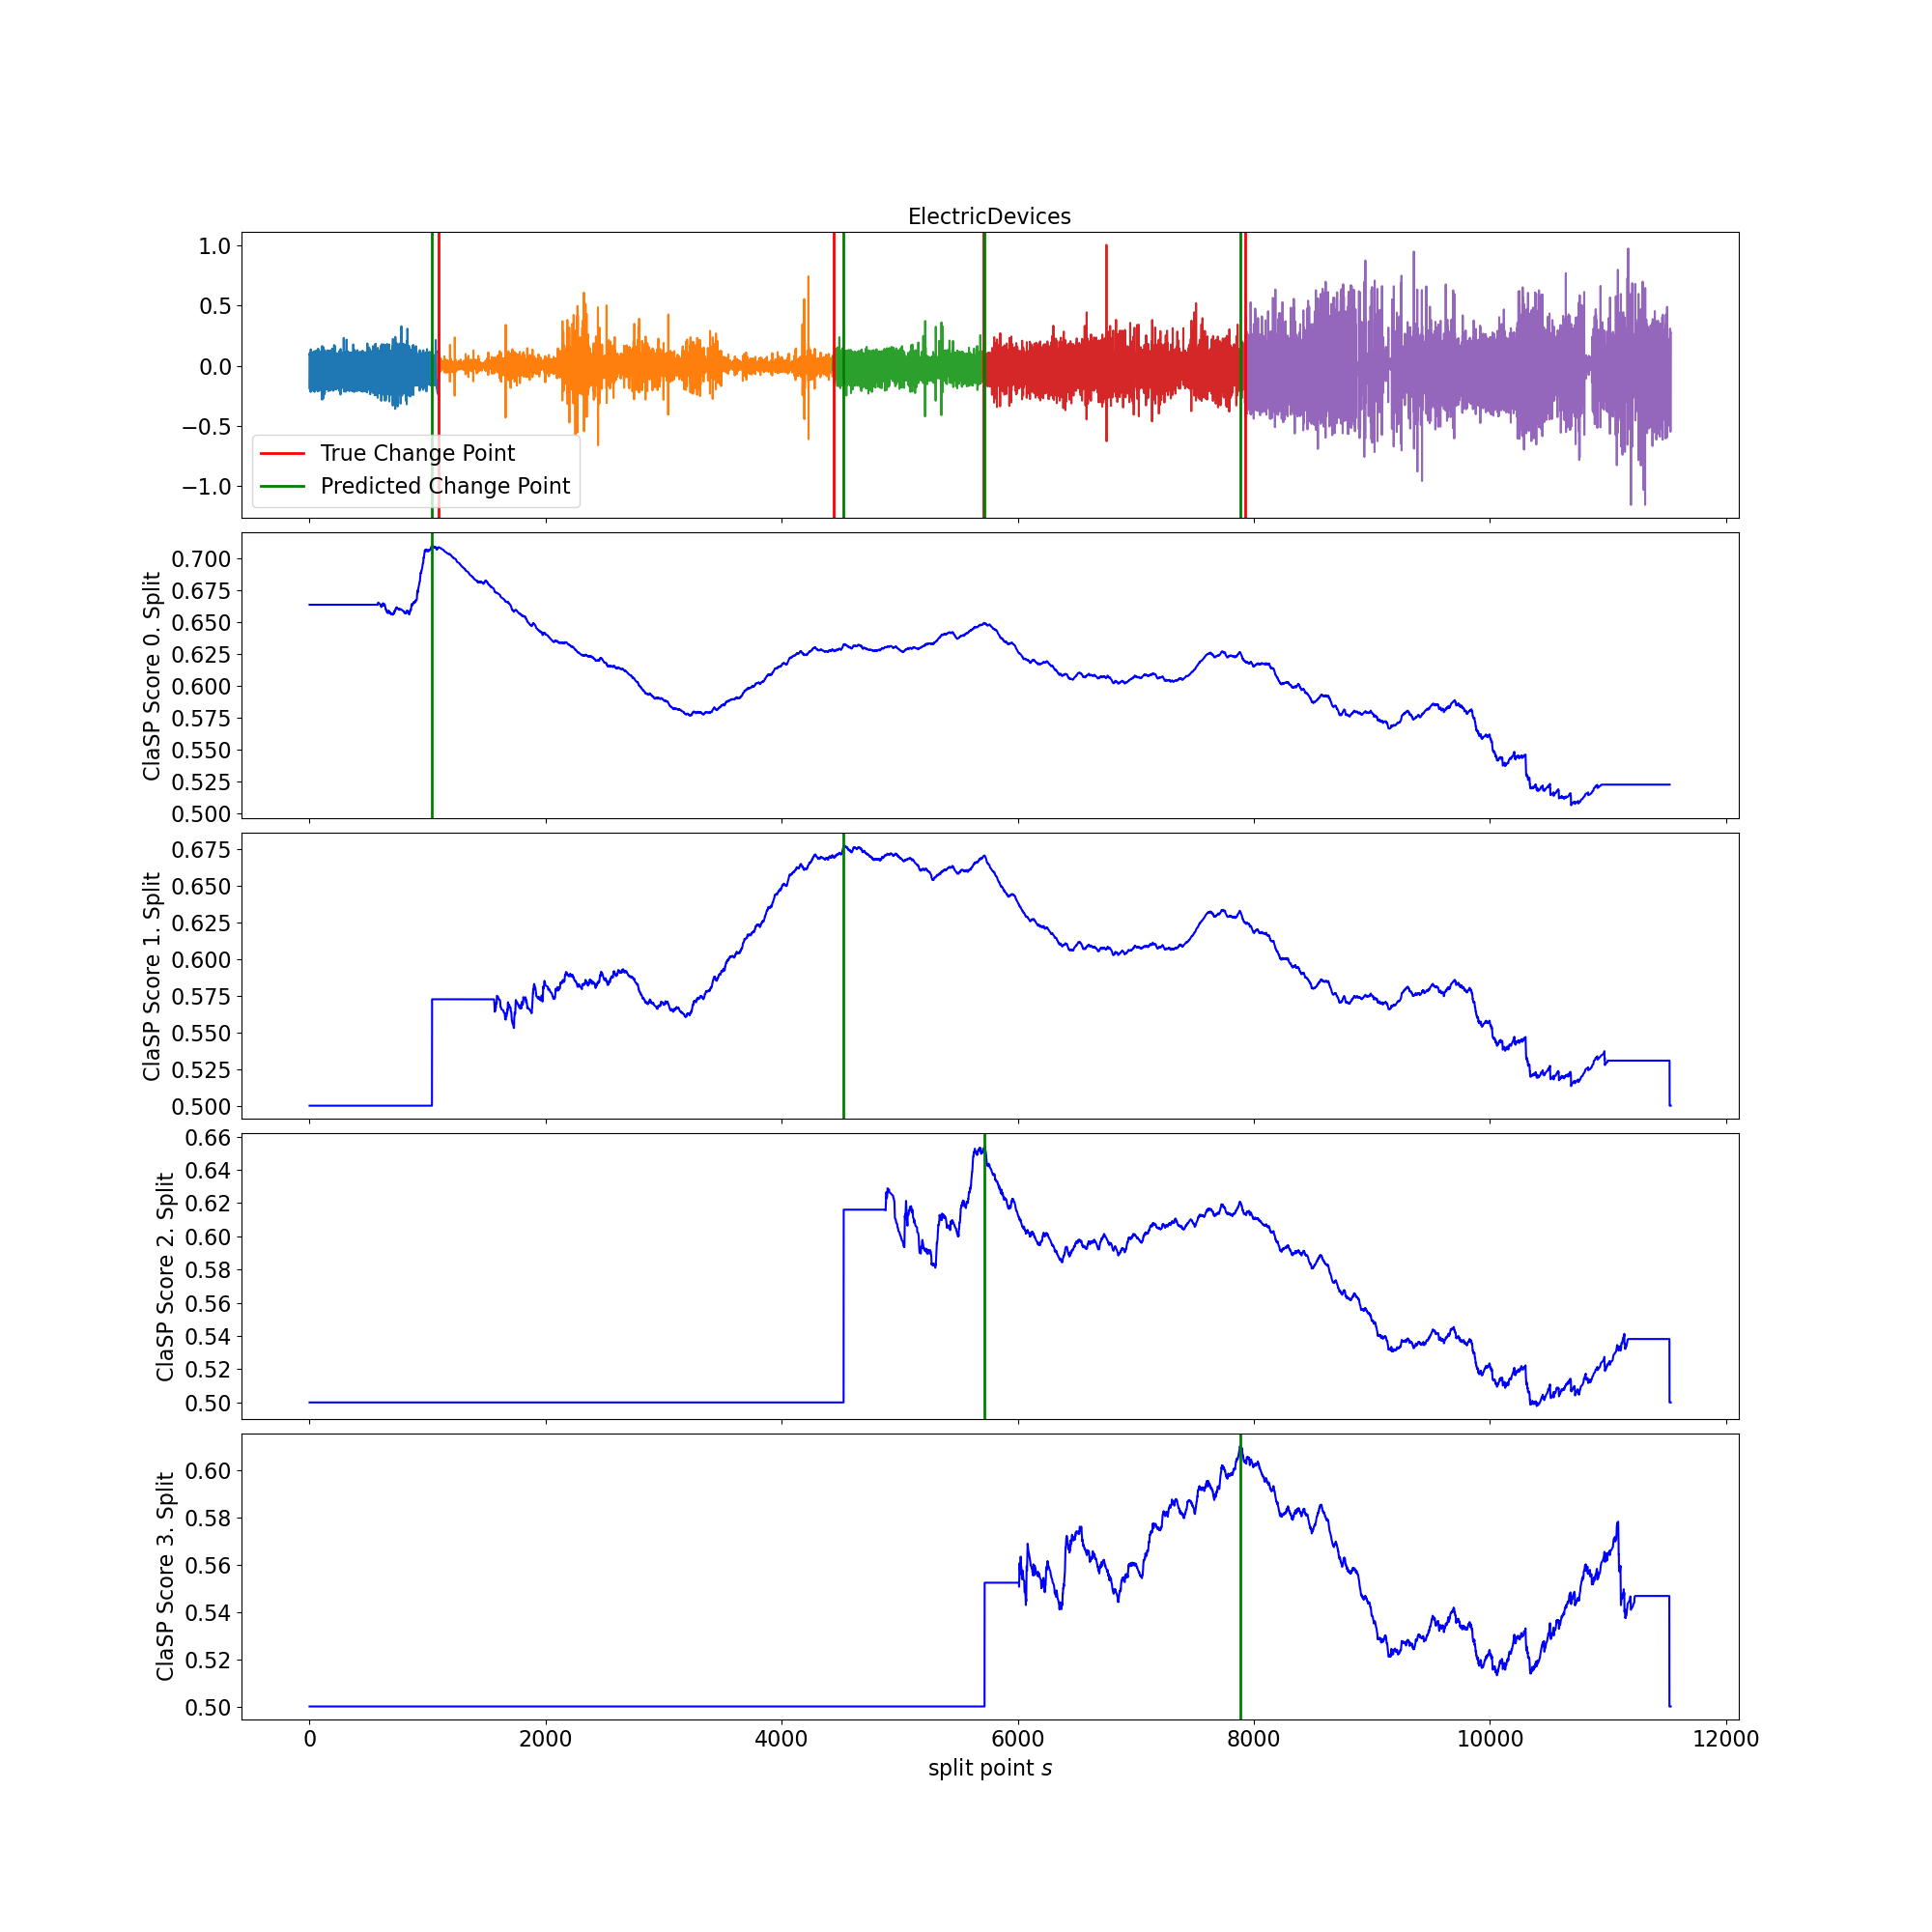

In [29]:
#| hide
ts, period_size, true_cps = load_electric_devices_segmentation()
_ = plot_series_with_change_points(ts, true_cps, title="Electric Devices")
dominant_period_size = find_dominant_window_sizes(ts)
print("Dominant Period", dominant_period_size)
#| hide
clasp = ClaSPSegmenter(period_length=dominant_period_size, n_cps=5)
found_cps = clasp.fit_predict(ts)
profiles = clasp.profiles
scores = clasp.scores

_ = plot_series_with_profiles(
    ts,
    profiles,
    true_cps=true_cps,
    found_cps=found_cps,
    title="ElectricDevices",
)

### Best nsizes sequence lengths

In [30]:
#| export
def find_dominant_window_sizes_list(
        X           : List [ float ], 
        nsizes      : int               = 1,
        offset      : float             = 0.05, 
        print_flag  : bool              = False,
        print_depth : int               = 1
    ) -> List [ int ]:

    if print_flag and print_depth > 0:
        print( "-----> Find_dominant_window_sizes_list -----" )
        print( "    X ~ ",  len(X) )
        print( "    Looking for - at most - the best", nsizes, "window sizes")
        print( "    Offset", offset, "max size:", offset*len(X))
        print( "Find_dominant_window_sizes_list | --> Freqs computed")
        
    X = np.array(X)
    
    fourier = np.absolute(np.fft.fft(X))   
    freqs = np.fft.fftfreq(X.shape[0], 1)
    
    if print_flag and print_depth > 0: 
        print( "Find_dominant_window_sizes_list | Freqs computed -->")
        print( "Find_dominant_window_sizes_list | --> Coefs and window_sizes")

    coefs = []
    window_sizes = []

    for coef, freq in zip(fourier, freqs):
        if coef and freq > 0:
            coefs.append(coef)
            window_sizes.append(1 / freq)

    coefs = np.array(coefs)
    window_sizes = np.asarray(window_sizes, dtype=np.int64)
    
    if print_flag and print_depth > 0: 
        print( "Find_dominant_window_sizes_list | Coefs and window_sizes -->")
        print( "Find_dominant_window_sizes_list | --> Find and return valid window_sizes")

    idx = np.argsort(coefs)[::-1]
    
    if print_flag and print_depth > 0: 
        print( "Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 0 ...", idx)
        
    sorted_window_sizes = window_sizes[idx]
    
    if print_flag and print_depth > 0: 
        print( "Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 1 ...")

    # Find and return all valid window sizes
    valid_window_sizes = [
        int(window_size / 2) for window_size in sorted_window_sizes
        #if 20 <= window_size < int(X.shape[0] * offset)
        if 20 <= window_size < int(len(X) * offset)
    ]
    
    if print_flag and print_depth > 0: 
        print( "Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 2 ...")

    # If no valid window sizes are found, return the first from sorted list
    if not valid_window_sizes:
        print( "Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 2a ...", nsizes)
        sizes = [sorted_window_sizes[0] // 2][:nsizes]
    else:
        print( "Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 2b ...", nsizes)
        sizes = valid_window_sizes[:nsizes]
        
    if print_flag and print_depth > 0: 
        print( "Find_dominant_window_sizes_list | Find and return valid window_sizes -->")
    
    if print_flag and print_depth > 0:
        print("    Sizes:", sizes)
        print( "----- Find dominant_window_sizes_list ----->" )
    
    return sizes

In [31]:
#| hide
find_dominant_window_sizes_list(ts, 5, 0.6, True)

-----> Find_dominant_window_sizes_list -----
    X ~  11532
    Looking for - at most - the best 5 window sizes
    Offset 0.6 max size: 6919.2
Find_dominant_window_sizes_list | --> Freqs computed
Find_dominant_window_sizes_list | Freqs computed -->
Find_dominant_window_sizes_list | --> Coefs and window_sizes
Find_dominant_window_sizes_list | Coefs and window_sizes -->
Find_dominant_window_sizes_list | --> Find and return valid window_sizes
Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 0 ... [3843 3842 3844 ...  110   79   84]
Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 1 ...
Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 2 ...
Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 2b ... 5
Find_dominant_window_sizes_list | Find and return valid window_sizes -->
    Sizes: [10, 10, 12, 11, 13]
----- Find dominant_window_sizes_list ----->


[10, 10, 12, 11, 13]

In [32]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


In [33]:
#| hide
foo = steam_df['steam flow']
dominant_period_size = find_dominant_window_sizes(
    foo, 
    offset = 0.05
)
print("Dominant Period ", dominant_period_size)
dominant_period_sizes = find_dominant_window_sizes_list(
    foo, 
    nsizes = 5, 
    offset = 0.05,
    print_flag = True
)
print("Dominant Period Sizes", dominant_period_sizes)
dominant_period_sizes = find_dominant_window_sizes_list(
    foo, 
    nsizes = 5, 
    offset = 0.6,
    print_flag = True
)
print("Dominant Period Sizes", dominant_period_sizes)

Dominant Period  191
-----> Find_dominant_window_sizes_list -----
    X ~  9600
    Looking for - at most - the best 5 window sizes
    Offset 0.05 max size: 480.0
Find_dominant_window_sizes_list | --> Freqs computed
Find_dominant_window_sizes_list | Freqs computed -->
Find_dominant_window_sizes_list | --> Coefs and window_sizes
Find_dominant_window_sizes_list | Coefs and window_sizes -->
Find_dominant_window_sizes_list | --> Find and return valid window_sizes
Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 0 ... [  24   11   25 ... 4521 1696 3503]
Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 1 ...
Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 2 ...
Find_dominant_window_sizes_list | Find and return valid window_sizes | ... 2b ... 5
Find_dominant_window_sizes_list | Find and return valid window_sizes -->
    Sizes: [191, 184, 141, 218, 160]
----- Find dominant_window_sizes_list ----->
Dominant Period S

## Distance Profile
The Distance Profile is used for comparing two time series, $T_A$ and $T_B$, by computing the distance of all subsequences of $T_A$ with the same length than $T_B$ and storing them into a distance vector:. 

$T_A$ - Time serie to compare to TB
$T_B$ - Reference time serie
$T_{A_i} = T_A^{(i,m)}$ - query subsequence

$DP_{AB}^{m} = ( d(TA_i,\, TB) )_{i=1}^{n-m+1}$

-  Compute the distance for each window/subsequence.

- The resulting vector of pairwise distances is also known as a distance profile.

#### More plotting auxiliar functions

In [34]:
#| export
def plot_subsequences_aux(
    ax              : plt.Axes, 
    x_coords        : List[ int ],  
    TA              : List [ float ], 
    subsequence_len : int, 
    i               : int   = 0, 
    distance        : float = 0, 
    print_flag      : bool  = False,
    print_depth     : int   = 1
) -> None:
    ax.clear()
    ax.plot(x_coords, TA, label='TA')
    if print_flag:
        print("TA[" + str(i) + "] start ", i, "end", i+subsequence_len)
    ax.plot(x_coords[i:i+subsequence_len], TA[i:i+subsequence_len], color='green', label='Subsequence' if i == 0 else "")
    ax.text(i + subsequence_len/2, (min(TA[i:i+subsequence_len]) + max(TA[i:i+subsequence_len])) / 2, f"{distance}", ha='center')
    ax.legend()
    ax.set_title('Euclidean distance ' + str(i))

def plot_subsequences(
    TA                  : List [ float ], 
    TB                  : List [ float ], 
    reference_i         : int,
    subsequence_len     : int, 
    distances           : List [ float ], 
    print_flag          : bool              = False,
    fig_size            : Tuple[int, int]   = (12, 10),
    print_depth         : int               = 1
) -> None:
    n = len(TA)
    x_coords = range(n)
    current_index = 0

    fig, (ax0, axN) = plt.subplots(
        2, 1, figsize=fig_size, sharex=True
    )

    # Plot the ax0 always on top
    if print_flag and print_depth > 0: print("--> Plotting ax0")
    ax0.plot(x_coords, TA, label='Time Series')
    if print_flag and print_depth > 0: print("adding TB ", subsequence_len, len(TB))
    ax0.plot(x_coords[reference_i:reference_i+subsequence_len], TB, color='darkgray', label='TB_reference')
    if print_flag and print_depth > 0: print("TB added")
    ax0.legend()
    ax0.set_title('Pairwise differences')
    if print_flag and print_depth > 0: print("Plotting ax0 done -->")
    # Function to handle button click to go to the next plot
    def on_next_clicked(b):
        nonlocal current_index
        if current_index < len(distances) - 1:
            current_index += 1
            plot_subsequences_aux(axN, x_coords, TA, subsequence_len, current_index, distances[current_index], print_flag, print_depth = print_depth -1)
            plt.tight_layout()
            plt.draw()

    # Function to handle button click to go to the previous plot
    def on_prev_clicked(b):
        nonlocal current_index
        if current_index > 0:
            current_index -= 1
            plot_subsequences_aux(axN, x_coords, TA, subsequence_len, current_index, distances[current_index], print_flag, print_depth = print_depth-1)
            plt.tight_layout()
            plt.draw()

    # Initialize the first subsequence plot
    plot_subsequences_aux(axN, x_coords, TA, subsequence_len, current_index, distances[current_index], print_flag, print_depth=print_depth-1)

    # Create and display prev/next buttons
    prev_button = widgets.Button(description='Previous')
    next_button = widgets.Button(description='Next')
    prev_button.on_click(on_prev_clicked)
    next_button.on_click(on_next_clicked)
    buttons = widgets.HBox([prev_button, next_button])
    display(buttons)

In [35]:
#| export
def plot_dataFrame(title, df, vars = [], interval = 10000):
    if len(vars) > 0:
        num_vars = len(df.columns)
    
        for var_num in vars:
            if var_num >= len(df.columns):
                raise ValueError("var_num "+var[var_num] + "is out of the range of DataFrame columns: " + num_vars)

        num_vars = len(vars)
        
        ### Start the plot 

        #fig = plt.figure(figsize=(10, num_intervals * 3))  # Ajusta el tamaño del plot según el número de intervalos
        
        num_intervals = df.shape[0] // interval + 1
        fig = plt.figure(figsize=(10, num_vars * num_intervals * 3))  ## Size
        gs = GridSpec(num_intervals*num_vars, 1) # 1 column, len(vars) rows
        var_pos = 0
        for var_num  in vars:
            var_name = df.columns[var_num]
            data = df[var_name]
            for i in range(num_intervals):    
                start_idx = i * interval
                end_idx = len(data) if i == (num_intervals - 1) else start_idx + interval
                ax = fig.add_subplot(gs[var_pos+i])
                ax.plot(np.arange(start_idx, end_idx), data[start_idx:end_idx], label=f"{var_name} [{start_idx}, {end_idx}]")
                ax.set_title(f"{var_name} [{start_idx}, {end_idx}]")
                ax.set_xlabel("Time")
                ax.set_ylabel(var_name)
                ax.legend()
            var_pos += 1
                
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()
    else: raise ValueError("No variable proposed for plotting")

In [36]:
#| export 
def plot_dataFrame_compareSubsequences(
    title, df, var, subsequence_len, seq1_init, seq2_init, 
    title_fontsize = '30',
    others_fontsize='20'
):
    fig, axs = plt.subplots(2)
    fig.subplots_adjust(hspace=0.4) 
    plt.suptitle(title, fontsize=title_fontsize)
    var_name = df.columns[var]
    axs[0].set_ylabel(var_name, fontsize=others_fontsize)
    axs[0].plot(df[var_name], alpha=0.5, linewidth=1)
    axs[0].plot(df[var_name].iloc[seq1_init:seq1_init+subsequence_len])
    axs[0].plot(df[var_name].iloc[seq2_init:seq2_init+subsequence_len])
    rect = Rectangle((seq1_init, 0), subsequence_len, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[0].set_xlabel("Index", fontsize=others_fontsize)

    rect = Rectangle((seq2_init, 0), subsequence_len, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel("Relative Index (subsequence)", fontsize=others_fontsize)
    axs[1].set_ylabel(var_name, fontsize=others_fontsize)
    axs[1].plot(df[var_name].values[seq1_init:seq1_init+subsequence_len], color='C1')
    axs[1].plot(df[var_name].values[seq2_init:seq2_init+subsequence_len], color='C2')
    plt.show()
    

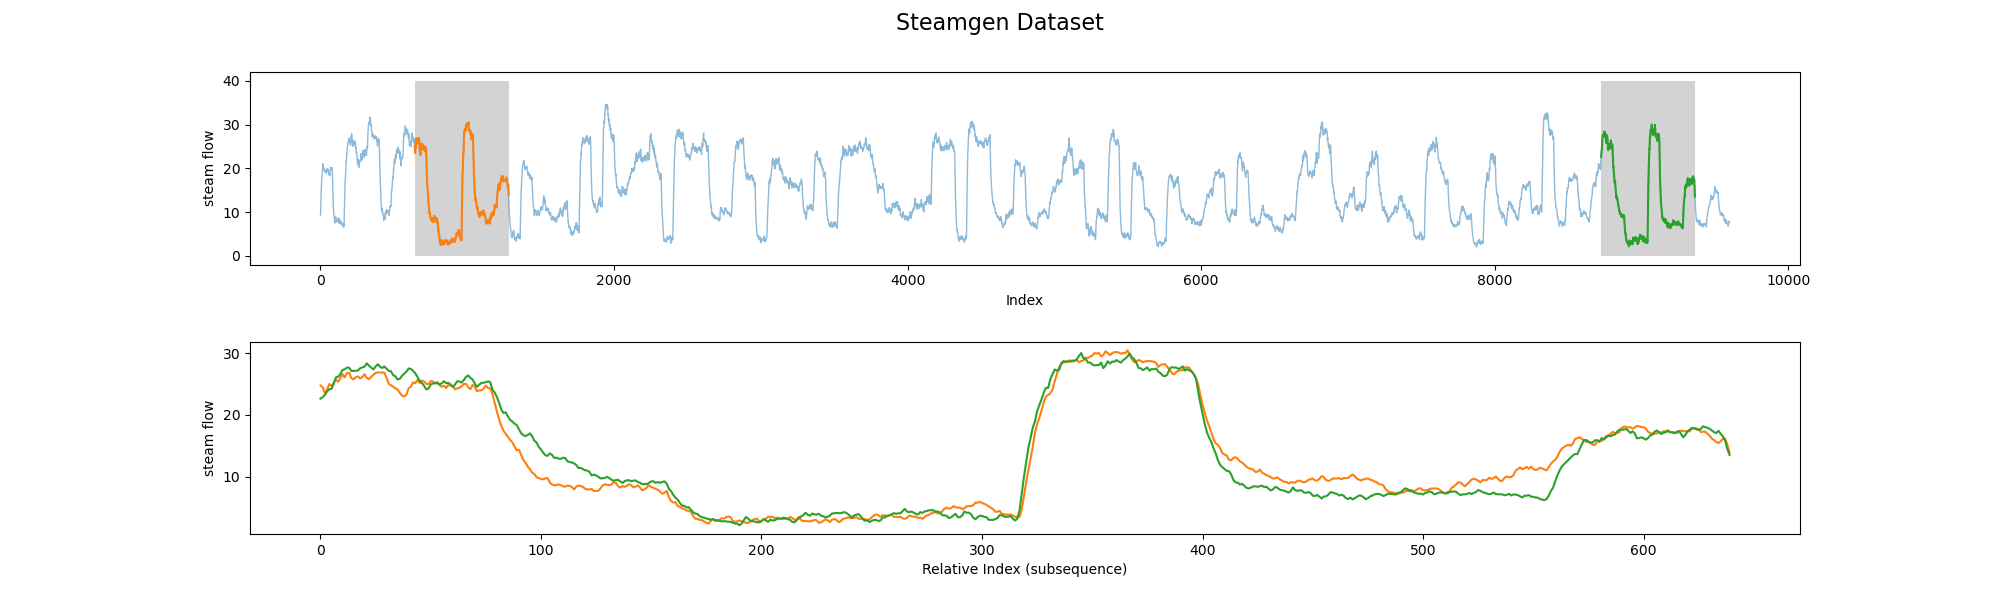

In [37]:
#| hide
plot_dataFrame_compareSubsequences('Steamgen Dataset', steam_df, 3, 640, 643, 8724, '16', '10')

In [38]:
#| export
def df_plot_colored_variables(df):
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    #df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    df.plot(colormap=cmap, ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    display(plt.show())

In [39]:
#| export
def plot_df_with_intervals_and_colors(title, df, interval=10000):
    num_variables = len(df.columns)
    num_intervals = len(df) // interval + 1  # Calcula el número necesario de intervalos/subplots

    fig = plt.figure(figsize=(10, num_intervals * 3 * num_variables))  # Ajusta el tamaño del plot
    gs = GridSpec(num_intervals * num_variables, 1)
    
    cmap = matplotlib.colormaps.get_cmap('viridis')

    for var_num, var in enumerate(df.columns):
        data = df[var]
        for i in range(num_intervals):
            ax = fig.add_subplot(gs[var_num * num_intervals + i])
            start_idx = i * interval
            end_idx = start_idx + interval

            if i == num_intervals - 1:  # Ajusta el último intervalo para incluir todos los datos restantes
                end_idx = len(data)

            color = cmap(var_num / num_variables)  # Asigna un color basado en la variable
            ax.plot(np.arange(start_idx, end_idx), data[start_idx:end_idx], label=f"{var} [{start_idx}, {end_idx}]", color=color)
            ax.set_title(f"{var} [{start_idx}, {end_idx}]")
            ax.set_xlabel("Index")
            ax.set_ylabel(var)
            ax.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

#### Auxiliar function for Distance Matrices
##### Checking similarity

In [40]:
#| export
def make_symmetric_(
        mat : List [ float ]
    ) -> None:
    """ Ensures down-left triangle equals to up-right triangle """
    for i in range(len(mat)):
       mat[i:,i] = mat[i,i:]
def check_symmetric(
        mat : List [ float ]
    ) -> bool:
    """ Check wether if down-left triangle equals to up-right triangle """
    sym = True
    i = 0
    while (i < len(mat) and sym):
        sym = np.array_equal(mat[i:,i], mat[i,i:])
        i+=1
    return sym


In [41]:
#| hide
foo = np.array([[1,2,3], [4,5,6], [7,8,9]])
print("--> Check 1")
print(check_symmetric(foo))
print(foo)
print("--> Make")
make_symmetric_(foo)
print(foo)
print("--> Check 2")
print(check_symmetric(foo))

--> Check 1
False
[[1 2 3]
 [4 5 6]
 [7 8 9]]
--> Make
[[1 2 3]
 [2 5 6]
 [3 6 9]]
--> Check 2
True


#####  Moving Mean

The next cell is code from [Zach - SCAMP (GitHub) ](https://github.com/zpzim/SCAMP/blob/b55f1baf31b03ffb824c22336919cecfbf40ea92/test/distance_matrix_fast.py)
modified to be able to use a prefixed minlag as in their MATLAB code.

In [42]:
#| export 
def moving_mean(a, w):
  result = np.zeros((len(a) - w + 1,))
  p = a[0]
  s = 0
  for i in range(1, w):
    x = p + a[i]
    z = x - p
    s += (p - (x - z)) + (a[i] - z)
    p = x
  
  result[0] = (p + s) / w

  for i in range(w, len(a)):
    x = p - a[i - w]
    z = x - p
    s += (p - (x - z)) - (a[i - w] + z)
    p = x

    x = p + a[i]
    z = x - p
    s += (p - (x - z)) + (a[i] - z)
    p = x
    result[i - w + 1] = (p + s) / w

  return result
def sum_of_squared_differences(a, means, w):
  result = np.zeros((len(a) - w + 1,))
  for i in range(len(a) - w + 1):
    vals = a[i:i+w] - means[i]
    vals = vals * vals
    result[i] = np.sum(vals)
  return result
def get_precomputes(T, m, nanvalues):
  flatness_epsilon = 1e-13
  n = len(T) - m + 1;
  df = np.zeros((n,))
  dg = np.zeros((n,))

  means = moving_mean(T,m)

  norms = sum_of_squared_differences(T, means, m)

  for i in range(n):
    if nanvalues[i]:
      norms[i] = np.nan
    elif norms[i] <= flatness_epsilon:
      norms[i] = np.nan
    else:
      norms[i] = 1.0 / math.sqrt(norms[i])

  for i in range(n-1):
    df[i] = (T[i + m] - T[i]) / 2.0;
    dg[i] = (T[i + m] - means[i + 1]) + (T[i] - means[i]);

  return means, norms, df, dg
def convert_non_finite_to_zero(T, m):
  timeseries_clean = np.zeros((len(T),))
  nanvals = np.zeros((len(T) - m + 1,))
  steps_since_last_nan = m
  for i in range(len(T)):
    if np.isfinite(T[i]):
      timeseries_clean[i] = T[i]
    else:
      steps_since_last_nan = 0
      timeseries_clean[i] = 0
    if i >= m - 1:
      nanvals[i - m + 1] = steps_since_last_nan < m
    steps_since_last_nan += 1
  return timeseries_clean, nanvals
# Computes the distance matrix using the diagonal update method used in SCAMP
def distance_matrix(a,b,w, minlag = None):
    warnings.warn(
        "Tried to use this function as in simMat but the MPlot gets really different. | TODO: Fix"
    )
    has_b = True
    if b is None:
        has_b = False
        b = a
    na = len(a) - w + 1
    if not has_b:
        nb = na
    else:
        nb = len(b) - w + 1
    out = np.ones((nb,na)) * -2


    a, nan_a = convert_non_finite_to_zero(a,w)
  
    if has_b:
      b, nan_b = convert_non_finite_to_zero(b,w)
    else:
      b = a

    mua, siga, dfa, dga = get_precomputes(a,w,nan_a)
    if not has_b:
        mub = mua
        sigb = siga
        dfb = dfa
        dgb = dga
    else:
        mub, sigb, dfb, dgb = get_precomputes(b,w, nan_b)

    diagmax = na
    if minlag is None:
      if not has_b:
        minlag = w // 4
      else:
          minlag = 0

    
    c = np.zeros((diagmax - minlag,)) 
    for diag in range(minlag,diagmax):
      c[diag-minlag] = np.sum((a[diag:diag+w]-mua[diag]) * (b[:w]-mub[0]))
    
    for offset in range(nb-minlag):
      result = c*(sigb[offset]*siga[minlag+offset:])
      out[offset, minlag+offset:] = result
      if not has_b:
        out[minlag+offset:, offset] = result
      x = c + dfb[offset] * dga[minlag+offset:] + dfa[minlag+offset:]*dgb[offset]
      c = x[:-1]
    if has_b:
      diagmax = nb
      c = np.zeros((diagmax - minlag,)) 
      for diag in range(minlag,diagmax):
        c[diag-minlag] = np.sum((b[diag:diag+w]-mub[diag]) * (a[:w]-mua[0]))
      for offset in range(na-minlag):
        result = c*(siga[offset]*sigb[minlag+offset:])
        out[minlag+offset:, offset] = result
        x = c + dfa[offset] * dgb[minlag+offset:] + dfb[minlag+offset:]*dga[offset]
        c = x[:-1]

    out[np.isnan(out)] = -2

    ### Added in a trial to get the same result as in SimMat (Matlab)
    out = np.sqrt(np.maximum(0, 2 * (w - out)));

    return out

### DistanceProfile class

In [44]:
#| export
@dataclass
class DistanceProfile:
    """ Vector of distances between each subsequence in TA and a reference sequence TB"""
    # Data to compare
    data            : List [ float ]= None
    # Reference data
    data_b          : List [ float ]= None
    data_b_i        : int           = 0
    self_join       : bool          = True
    subsequence_len : Optional[int] = None
    # Distance profile
    distances: List[float]          = field(default_factory=list),
    # Figure
    mplot                           = None,
    # Method used for building the DistanceProfile
    method                          = 'naive',
    computation_time: float         = 0.0
    dominant_lens   : List[ int ]   = None
    shape           : Tuple[ int, int ] = 0,0
    def provide_lens(
        self        : 'DistanceProfile',
        nlens       : int               = 1,
        offset      : float             = 0.05,
        print_flag  : bool              = False,
        print_depth : int               = 1
    ) -> List [ int ]:
        if nlens == 1:
            if print_flag and print_depth > 0: print(f"Computing {nlens} dominant lens")
            self.subsequence_len = find_dominant_window_sizes(self.data, offset = offset)
            self.dominant_lens = [self.subsequence_len]
        else:
            if print_flag: print(f"Computing {nlens} dominant lens")
            self.dominant_lens = find_dominant_window_sizes_list(
                self.data,
                nsizes      = nlens,
                offset      = offset,
                print_flag  = print_flag,
                print_depth = print_depth
            )
            self.subsequence_len = self.dominant_lens[0]
    
    def compute(
        self            : 'DistanceProfile',
        min_lag         : int               = None,
        d               : Callable          = euclidean_distance,
        method          : str               = 'naive',
        fig_size        : tuple             = (12, 10),
        print_flag      : bool              = False,
        plot_flag       : bool              = True,
        time_flag       : bool              = False,
        ensure_symetric : bool              = False,
        provide_len     : bool              = True,
        nlens           : Optional [ int ]  = 1,
        print_depth     : int               = 1
    ) -> Tuple[ List [ float ], ut.Time ]:
        """ Compute the Distance Profile """    
        t = None
        if time_flag:
            t = ut.Time(function=ut.funcname())
            t.start(print_flag and print_depth > 0)
        

        if self.subsequence_len is None:
            if provide_len or self.data_b is None:
                self.provide_lens(nlens = nlens, print_flag = print_flag, print_depth = print_depth-1)
            else:
                self.subsequence_len = len(self.data_b)
        
        if (self.self_join): 
            if print_flag : print("--> Self join", "TB_i", self.data_b_i, "TA", self.data)
            self.data_b = self.data[self.data_b_i:self.data_b_i+self.subsequence_len]

        #if print_flag:
            #print("TA: ", self.data)
            #print("TB: ", self.data_b)
        

        n_a = len(self.data)
        m = self.subsequence_len
        expected_size = n_a - m + 1

        if print_flag and print_depth > 0: print("Expected_size", expected_size)
        self.method = method
        match self.method:
            case 'stumpy.mass':
                if print_flag and print_depth > 0: print("--> Using stumpy.mass")
                if (d.__name__ == 'z_normalized_euclidean_distance'):
                    if print_flag and print_depth > 0: print("Normalized")
                    self.distances = stump.core.mass(
                        Q = self.data_b[self.data_b_i:self.data_b_i+m].astype(np.float64),
                        T = self.data.astype(np.float64)
                    )
                else:
                    if print_flag: print("Non-Normalized")
                    self.distances = stump.core.mass(
                        Q = self.data_b[self.data_b_i:self.data_b_i+m].data.astype(np.float64),
                        T = self.data.astype(np.float64),
                        normalize = False
                    )
            case _:
                if print_flag and print_depth > 0: print("--> Using naive made distance profile [ default | Not recommended ]")
                
                self.distances = np.zeros(expected_size)
                if print_flag and print_depth > 0: print(f"--> Computing distances TA ~ {n_a} TB ~ {len(self.data_b)}")
                for i in range(expected_size):
                    vector_a = self.data[i:i+m]
                    vector_b = self.data_b[self.data_b_i:self.data_b_i+m]
                    if print_flag and print_depth > 0: 
                        print(f"[DP] Computing distance {i} \nTA: {vector_a.shape},\nTB ~ {vector_b.shape}")
                    #    print(f"[DP] Computing distance {i} \nTA: {self.data},\nTB: {self.data_b[self.data_b_i:self.data_b_i+m]}")
                    self.distances[i] = d (
                        vector_a    = vector_a,
                        vector_b    = vector_b,
                        print_flag  = print_flag,
                        time_flag   = time_flag,
                        print_depth = print_depth-1
                    )[0] #Returns (distance, time)
            
        
        if (ensure_symetric):
            make_symmetric_(self.distances)
            
        if plot_flag: 
            if print_flag: print("--> plot")
            plot_subsequences(
                self.data,
                self.data_b,
                self.data_b_i, 
                len(self.data_b), 
                self.distances,
                fig_size = fig_size
            )
        if time_flag: 
            t.end(print_flag)
            t.show()
            self.computation_time = t.time_total
        
        self.shape = self.distances.shape

        return self.distances, t
    
    def plot_subsequence_compared(
        self,
        sequence_i  : int = 0,
        print_flag  : bool = False,
        fig_width   : int = 12,
        print_depth : int = 1
    ) -> None:
        if (self.data_b is None or self.self_join) :
            if print_flag: print("--> TB = TA")
            self.data_b = self.data
        n = len(self.data)
        m = self.subsequence_len
        expected_size = n - m + 1
        x_coords = range(n)
        if print_flag and print_depth > 0:
            print("expected size", expected_size)
            print("--> Getting height")
        fig_height_in = 0.59 *2 + 2
        fig, axs = plt.subplots(2, 1, figsize=(fig_width, fig_height_in), sharex=True)
        if print_flag and print_depth > 0: print("--> TB")
        TB_sub = self.data_b[self.data_b_i: m]
        if print_flag and print_depth > 0: print("TA", self.data, len(self.data))
        if print_flag and print_depth > 0: print("TB", self.data_b, len(self.data_b), " subsequence ", self.data_b_i, m, TB_sub)
        axs[0].plot(x_coords, self.data_b, label='Time Series')
        if print_flag : print("m", m, "TB_i", self.data_b_i, "TB_i+m", self.data_b_i+m)
        axs[0].plot(x_coords[self.data_b_i:self.data_b_i+m], TB_sub, color='darkgray', label='TB_reference')
        axs[0].legend()
        axs[0].set_title('Pairwise differences')

        if print_flag and print_depth > 0: print("--> TA")
        axs[1].plot(x_coords, self.data, label='TA')
        i = sequence_i
        axs[1].plot(x_coords[i:i+m], self.data[i:i+m], color='green', label='Subsequence' if i == 0 else "")
        axs[1].text(i + m/2, (min(self.data[i:i+m]) + max(self.data[i:i+m])) / 2, f"{self.distances[i]:.2f}", ha='center')
        axs[1].legend()
        axs[1].set_title('Euclidean distance ' + str(i))
        plt.tight_layout()
        plt.show()

#### Example of use: Stumpy's Time Serie of length 13

[ 0.          7.41619849  6.8556546  14.69693846 19.26136028 17.74823935
 19.89974874 15.03329638  8.18535277  8.88819442]


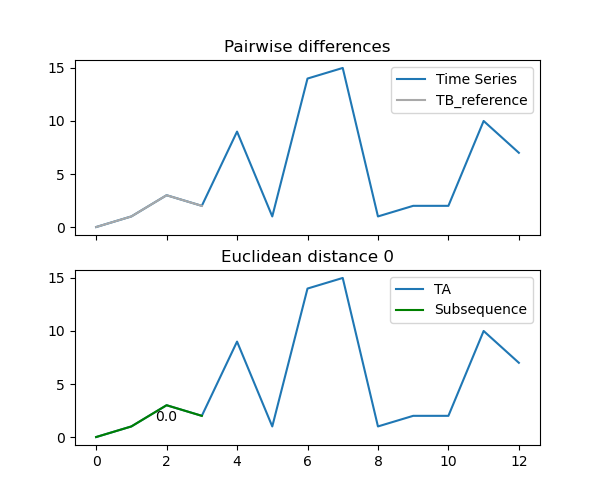

In [45]:
#| hide
%matplotlib widget
foo_data = np.array([0, 1, 3, 2, 9, 1, 14, 15, 1, 2, 2, 10, 7])
foo_ref_i = 0
foo_subseq_len = 4
foo_DP_AB = DistanceProfile(
    data = foo_data, 
    data_b = None,
    self_join= True,
    data_b_i = foo_ref_i,
    subsequence_len = foo_subseq_len
)
foo_DP_AB.compute(
    print_flag = False, 
    plot_flag = True, 
    d = euclidean_distance,
    fig_size = (6,5),
    method = 'naive'
)
print(foo_DP_AB.distances)

Distances:  [ 0.          7.41619849  6.8556546  14.69693846 19.26136028 17.74823935
 19.89974874 15.03329638  8.18535277  8.88819442]
Best match id:  0
Best match distance 0.0


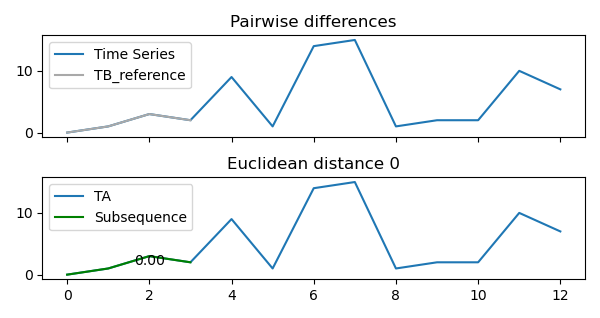

worst match id:  6
worst match distance 19.8997487421324


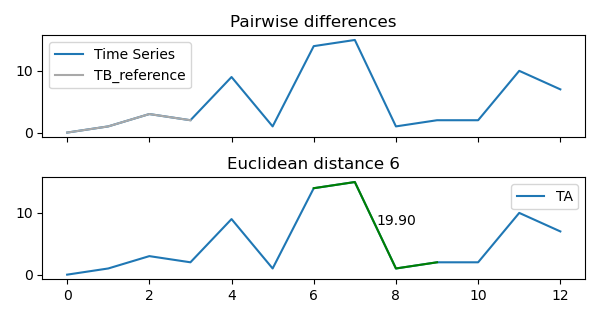

In [46]:
#| hide
print("Distances: ", foo_DP_AB.distances)
foo_best_match_dist = np.nanmin(foo_DP_AB.distances)
best_match_id = np.where(foo_DP_AB.distances == foo_best_match_dist)[0][0]

print("Best match id: ", best_match_id)
print("Best match distance", foo_best_match_dist)

foo_DP_AB.plot_subsequence_compared(best_match_id, False, fig_width=6)

foo_worst_match_dist = np.nanmax(foo_DP_AB.distances)
foo_worst_match_id = np.where(foo_DP_AB.distances == foo_worst_match_dist)[0][0]
print("worst match id: ", foo_worst_match_id)
print("worst match distance", foo_worst_match_dist)
foo_DP_AB.plot_subsequence_compared(foo_worst_match_id, False, fig_width = 6)

#### Using proposed window size

Sequence length: None


Sequence length: 4
[ 0.          7.41619849  6.8556546  14.69693846 19.26136028 17.74823935
 19.89974874 15.03329638  8.18535277  8.88819442]
Distances:  [ 0.          7.41619849  6.8556546  14.69693846 19.26136028 17.74823935
 19.89974874 15.03329638  8.18535277  8.88819442]
Best match id:  0
Best match distance 0.0


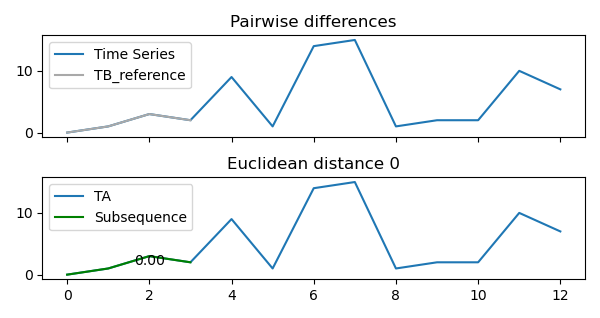

worst match id:  6
worst match distance 19.8997487421324


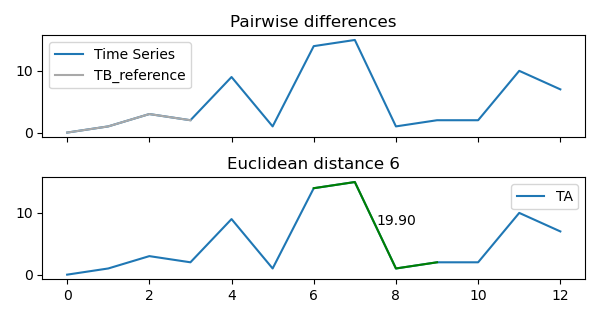

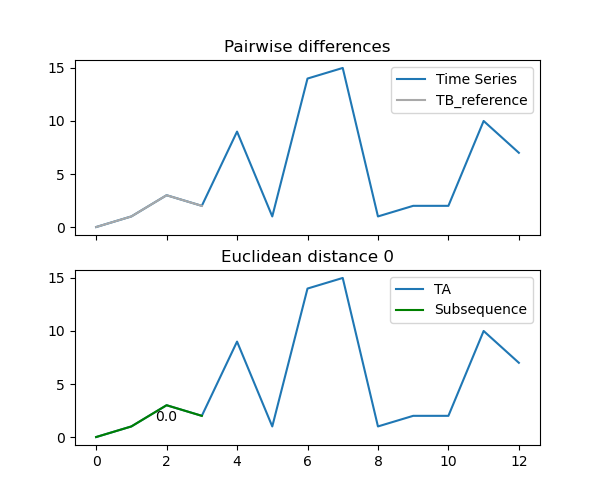

In [47]:
#| hide
%matplotlib widget
foo_data = np.array([0, 1, 3, 2, 9, 1, 14, 15, 1, 2, 2, 10, 7])
foo_ref_i = 0
foo_DP_AB = DistanceProfile(
    data = foo_data, 
    data_b = None,
    self_join= True,
    data_b_i = foo_ref_i,
)
print(f"Sequence length: {foo_DP_AB.subsequence_len}")
foo_DP_AB.compute(
    print_flag = False, 
    plot_flag = True, 
    d = euclidean_distance,
    fig_size = (6,5),
    method = 'naive'
)
print(f"Sequence length: {foo_DP_AB.subsequence_len}")
print(foo_DP_AB.distances)
print("Distances: ", foo_DP_AB.distances)
foo_best_match_dist = np.nanmin(foo_DP_AB.distances)
best_match_id = np.where(foo_DP_AB.distances == foo_best_match_dist)[0][0]

print("Best match id: ", best_match_id)
print("Best match distance", foo_best_match_dist)

foo_DP_AB.plot_subsequence_compared(best_match_id, False, fig_width=6)

foo_worst_match_dist = np.nanmax(foo_DP_AB.distances)
foo_worst_match_id = np.where(foo_DP_AB.distances == foo_worst_match_dist)[0][0]
print("worst match id: ", foo_worst_match_id)
print("worst match distance", foo_worst_match_dist)
foo_DP_AB.plot_subsequence_compared(foo_worst_match_id, False, fig_width = 6)

## Piecewise Aggregate Approximation

In [48]:
#| export
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline

In [49]:
#| export
class Interpolator(BaseEstimator, TransformerMixin):
    def __init__(
        self              : 'Interpolator', 
        method            : str  ='linear', 
        n_segments        : int  = 1, 
        plot_original_data: bool = False,
        plot_interpolated : bool = False,
        print_flag        : bool = False,
        
    ):
        self.method             = method
        self.n_segments         = n_segments
        self.plot_interpolated  = plot_interpolated
        self.plot_original_data = plot_original_data
        self.print_flag         = print_flag

    def fit(self, X, y=None):
        return self

    def transform(self, X):
    
                
        if X.ndim == 1:
            X = X.reshape(1, -1)

        if self.plot_original_data:
            if self.print_flag: print("Interpolator | Plot original data")
            for dim in range (X.ndim-1):
                if self.print_flag: print(f"Interpolator | Plot original data dimension {dim}")
                plot_with_dots(
                    X[dim], 
                    sequence_flag = False, 
                    title = f'Original data | dim {dim}'
                )
                
        n_samples, n_features = X.shape
        if n_features % self.n_segments != 0:
            raise ValueError(
                f"El número de segmentos {self.n_segments} debe dividir el número de características {n_features} | Reminder: {n_features // self.n_segments}"
            )

        segment_size = n_features // self.n_segments
        interpolated_result = np.full_like(X, np.nan)

        for i in np.arange(self.n_segments):
            start = i * segment_size
            end = start + segment_size
            segment_mean = np.nanmean(X[:, start:end], axis=1)
            for j in np.arange(n_samples):
                nan_mask = np.isnan(X[j, start:end])
                interpolated_result[j, start:end][nan_mask] = segment_mean[j]
        res = np.where(np.isnan(X), interpolated_result, X)
        if self.plot_interpolated:
            for dim in range (X.ndim-1):
                plot_with_dots(
                    res[dim], 
                    sequence_flag = False, 
                    title = f'Interpolated data | dim {dim}'
                )
            
        return res

In [57]:
#| export
class PAATransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self, 
        n_segments, 
        plot_aggregated : bool = False, 
        print_flag      : bool = False
    ):
        self.n_segments = n_segments
        self.plot_aggregated = plot_aggregated
        self.print_flag = print_flag

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples, n_features = X.shape
        if n_features < self.n_segments:
            raise ValueError("El número de segmentos no puede ser mayor que el número total de puntos.")

        segment_size = n_features // ( self.n_segments + 1)
        remainder = n_features % ( self.n_segments + 1)

        # Crear un array para los resultados
        result = np.zeros((n_samples, self.n_segments + 1))

        # Procesar cada segmento
        for i in range(self.n_segments+1):
            start = i * segment_size + min(i, remainder)
            end = start + segment_size + (1 if i < remainder else 0)
            result[:, i] = np.mean(X[:, start:end], axis=1)

        if self.plot_aggregated:
            for dim in range (X.ndim-1):
                if self.print_flag:
                    print("Plos res | Dim", dim)
                plot_with_dots(
                    result[dim], 
                    sequence_flag = False, 
                    title = f'Aggregated data | dim {dim}'
                )

        return result


In [51]:
#| hide 
plt.close('all')

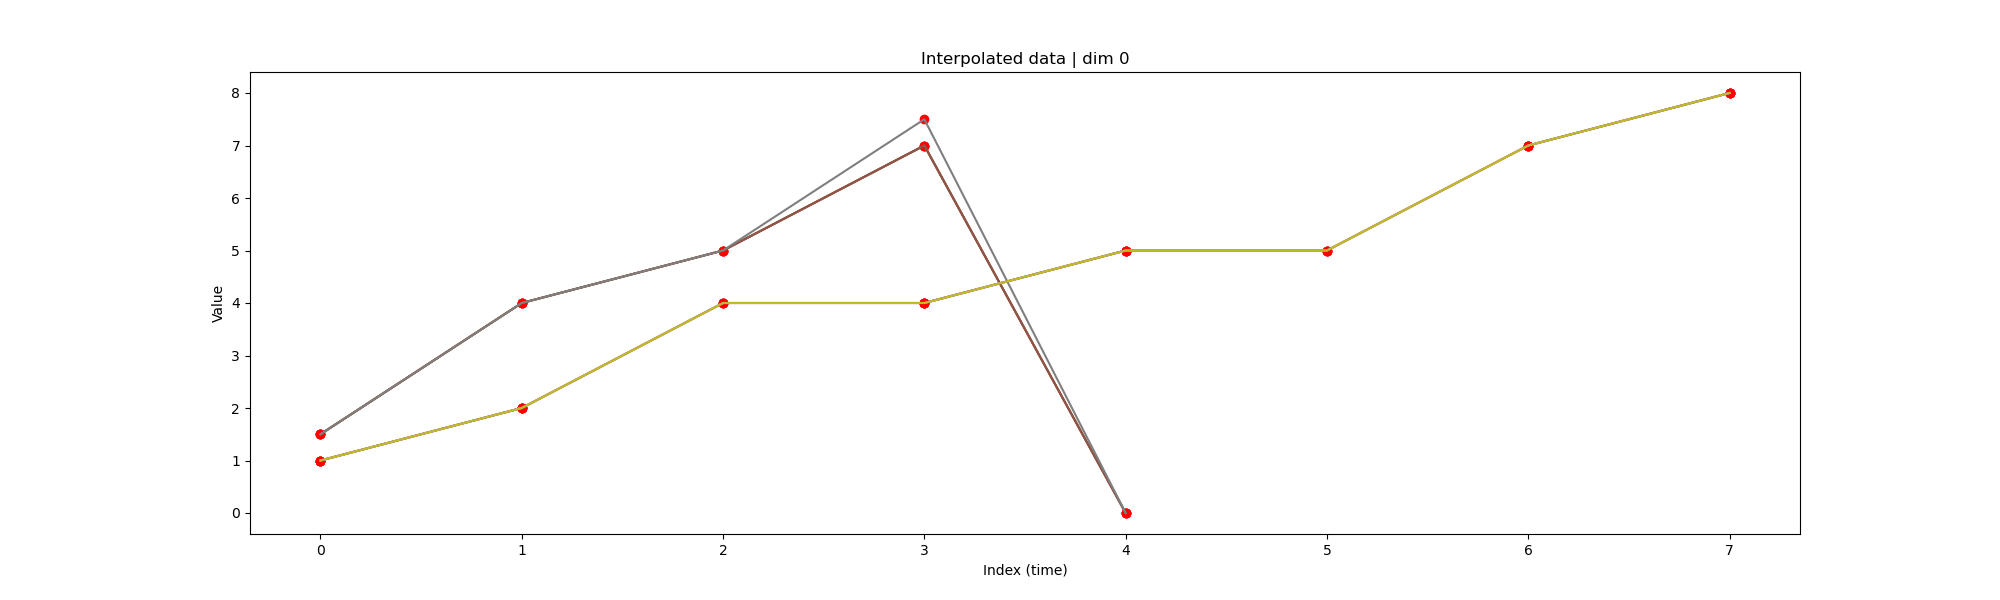

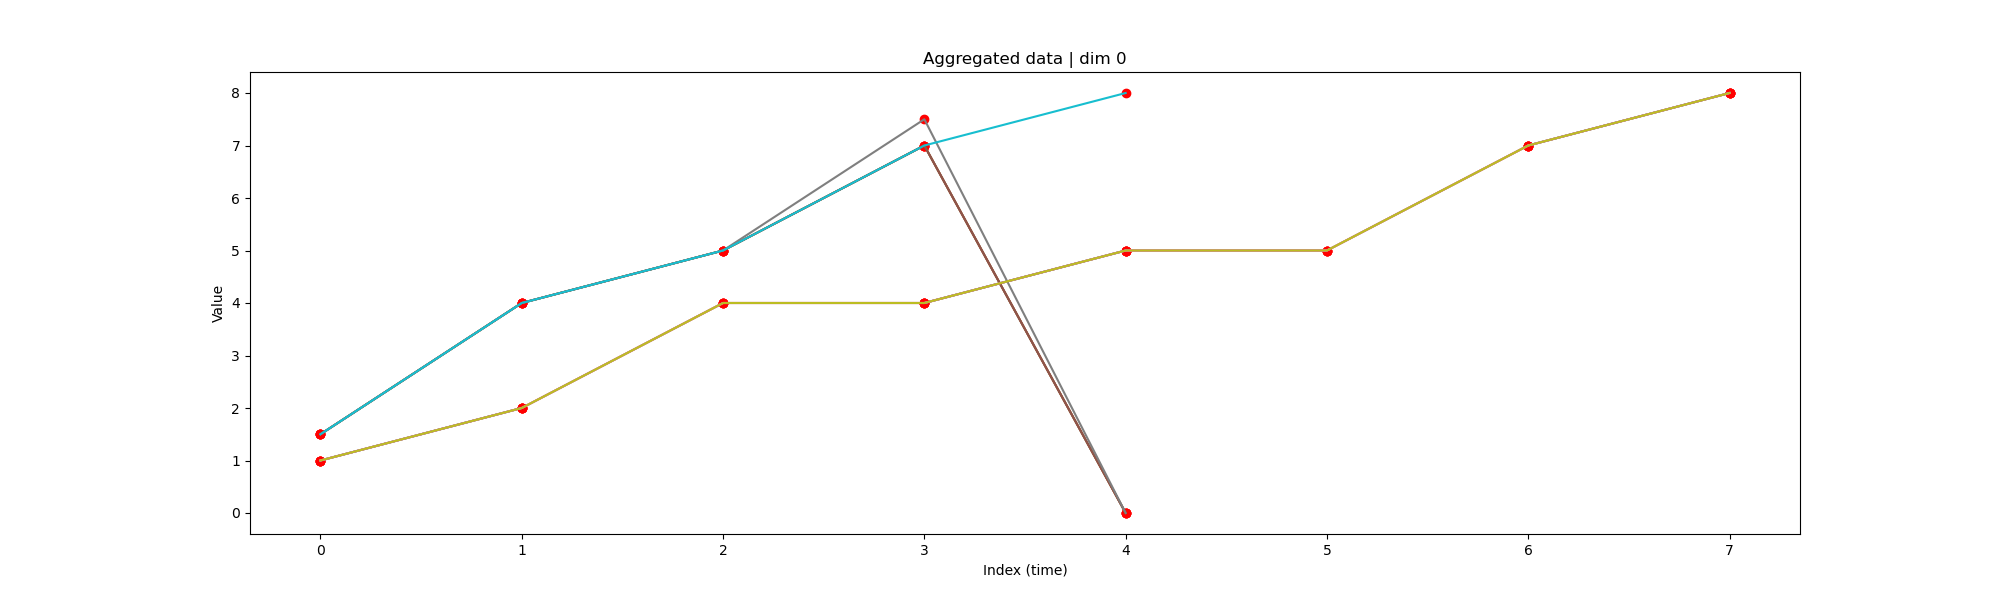

In [58]:
#| hide
foo_data = np.array([1.0, 2.0, np.nan, 4.0, 5.0, np.nan, 7.0, 8.0])
foo_paa_pipeline = Pipeline([
    (
        # Step for interpolating NaNs in the original data
        'interpolator', 
        Interpolator(
            method='polynomial', 
            n_segments         = 4, 
            plot_interpolated  = True,
            plot_original_data = False,
            print_flag         = False
        )
    ),
    (
        # Step for applying Peicewise Aggregated Approximation
        'paa', PAATransformer(
            n_segments      = 4, 
            plot_aggregated = True, 
            print_flag      = False
        )
    )
])


foo = foo_paa_pipeline.fit_transform(foo_data)[0]




## Distance Matrix / Similarity Matrix

### Definition 5: Distance Matrix / Similarity matrix
Now, if we want to compare two series in all their points and not only TA vs a subsequence of TB, we can swift TB subsequence like we did with TA.
When all Distances Profiles are joined by rows in a matrix, this matrix is called Distance Matrix or Similarity Matrix

- TA query time serie
- TB reference time serie to compare with

$DM_{A,B}^{m}=(DP^m_{A,B^{(j,m)}})_{j=0}^{n_{B} - m + 1 ↓} = (d(T_A^{(i,m)},T_B^{(j,m)}))_{i,j=0}^{n_{A}-m+1 \to,n_{B} - m + 1 ↓}$


- Each row is a vector of distances => Got a matrix of distances

In [ ]:

#| export 
@dataclass
class DistanceMatrix: 
    """ Similarity matrix """
    # -- Similarity Matrix
    distances       : List[ List [ float ] ]    = field(default_factory=list)
    # -- Time series A (Query Time Serie
    data            : List [ float ]            = None
    # -- Reference sequence
    data_b          : Optional[ List [ float ]] = None
    ## -- If comparing to a subsequence of the own matrix
    self_join       : bool                      = True
    data_b_i        : int                       = 0
    # -- 
    subsequence_len : Optional[ int ]           = None
    method          : str                       = 'naive'
    computation_time: float                     = 0.0
    dominant_lens   : List[ int ]               = None
    shape           : Tuple[ int, int ]         = (0,0)

    def provide_lens(
        self        : 'DistanceMatrix',
        nlens       : int               = 1,
        offset      : float             = 0.05,
        print_flag  : bool              = False,
        print_depth : int               = 1
    ) -> List [ int ]:
        if nlens == 1:
            self.subsequence_len = find_dominant_window_sizes(self.data, offset = offset)
            self.dominant_lens = [self.subsequence_len]
        else:
            self.dominant_lens = find_dominant_window_sizes_list(
                self.data,
                nsizes      = nlens,
                offset      = offset,
                print_flag  = print_flag
            )
            self.subsequence_len = self.dominant_lens[0]

    def load_data_from_matlab(
        self, 
        matrix              : MatlabMatrix = None,
        filename            : str = None,
        matname             : str = None,
        smoothing_window_len: int = None,
        path                : str = ".",
        numcol              : int  = 0,
        force_smooth        : bool = False,
        set_a_or_b          : bool = True,
        print_flag          : bool = False,
        print_depth         : int = 1
    ) ->  List [ float ] :
        if matrix is None:
            matrix = MatlabMatrix(
                filename = filename, 
                matname = matname,
                smoothing_window_len = smoothing_window_len,
                path = path
            )
        matrix_data = matrix.load(
            numcol, print_flag, force_smooth, path
        )

        if (set_a_or_b):   
            if print_flag and print_depth > 0: print("Copy A")
            self.data = deepcopy(matrix_data)
        else: 
            if print_flag and print_depth > 0: print("Copy B")
            self.data_b = deepcopy(matrix_data)

        return matrix_data
        
    
    def compute(
        self                : 'DistanceMatrix',
        method              : 'str'         = 'naive',
        d                   : Callable      = z_normalized_euclidean_distance,
        ensure_symetric     : bool          = True,
        #--- Scamp
        mheight             : int           = None,
        mwidth              : int           = None,
        #--- Octave functions expected parameters ---
        min_lag             : int           = 0, #May be needed if SimMat is used
        #--- may be needed by runsplat, splat & piecewiseSplat
        multiresolution     : int           = 0,
        calibration         : int           = 0,
        piecewise           : bool          = False,
        patch_size          : int           = 5000, #Size of patches to compute (the final matrix, similar to mheight, mwidht)
        print_flag          : bool          = False,
        plot_flag           : bool          = False,
        time_flag           : bool          = True,
        allow_experimental  : bool          = True, # Allows the use of experimental code when specified in the used libraries
        parallel            : bool          = False, # Some parts of the code can be parallelized. Not very tested.
        threads             : int           = 4,    # Threads for parallelization 
        provide_len         : bool          = True, # Wether if subsequence length is provided or calculated via Fourier Transformation
        nlens               : int           = 1,    # How many lengths to get from Fourier's transform
        gpus                : List [ int ]  = None, # Gpus to use
        pearson             : bool          = True,    # Wether to apply or not pearson correlation. Needed by scamp,
        print_depth         : int           = 1,
        debug               : bool          = False
    ) -> Tuple [ List [ List [ float ] ], Optional [ ut.Time ] ] :
        t = None

        complete                    = ( self.data_b is None )
        n                           = len(self.data)
                
        if self.subsequence_len is None:
            if provide_len or self.data_b is None:
                self.provide_lens(nlens = nlens, print_flag = print_flag, print_depth = print_depth-1)
            else:
                self.subsequence_len = len(self.data_b)
        
        columns = n - self.subsequence_len + 1
        
        if (self.self_join): 
            if print_flag and print_depth > 0: print("[ DistanceMatrix | Compute ]  --> Self_join")
            rows = columns
            reference_seq = self.data
            
        else: #AB-join
            if print_flag and print_depth > 0: print("[ DistanceMatrix | Compute ] | --> AB-join")
            reference_seq = self.data_b
            rows = len(reference_seq) - self.subsequence_len + 1
        if print_flag and print_depth > 0:
            print(f"[ DistanceMatrix | Compute ] | reference_seq ~ {len(reference_seq)} | subsequence_len ~ {self.subsequence_len} | rows {rows} | columns {columns}")
        sys.stdout.flush()    

        self.distances = np.empty((rows, columns))

        if print_flag and print_depth > 0: 
            print(f"[ DistanceMatrix | Compute ] | Rows: {rows} Columns: {columns} | distances ~ {self.distances.shape}")
            
        if time_flag: 
            timer = ut.Time()
            timer.start(print_flag = print_flag and print_depth > 0)

        DP_AB : DistanceProfile = None
        

        match method:
            case 'stump':
                self.method = 'stump'
                if print_flag and print_depth > 0: print("--> Stump")
                if self.data_b is None: 
                    data_b = deepcopy(self.data)
                else: 
                    data_b = deepcopy(self.data_b)
                DP_AB = DistanceProfile(self_join = self.self_join, subsequence_len = self.subsequence_len )
                if not parallel:
                    print ("Not parallel")
                    DP_AB.data            = self.data
                    DP_AB.data_b          = deepcopy(data_b)
                    DP_AB.data_b_i        = 0
        
                
                def compute_distance_i(i : int) -> List [ float ]:
                    nonlocal DP_AB

                    if parallel:
                        if print_flag and print_depth > 0: print(f"Creating {i} ~ DP_AB")
                        DP_AB_ = DistanceProfile(
                            data            = deepcopy(self.data),
                            data_b          = deepcopy(data_b),
                            data_b_i        = i,
                            self_join       = self.self_join, 
                            subsequence_len = self.subsequence_len
                        )

                    else:
                        DP_AB_ = DP_AB
                        DP_AB_.data_b_i = i
                        DP_AB.data_b = data_b

                    DP_AB_.compute(
                        print_flag  = print_flag,
                        plot_flag   = plot_flag,
                        d           = d,
                        method      ='stumpy.mass',
                        print_depth = print_depth-1
                    )

                    if print_flag  and print_depth > 0:
                        print(f"DP {i} = {DP_AB_.distances}")
                        print(f"DP {i} ~ {DP_AB_.distances.shape}")
                    
                    return DP_AB_.distances
                
                if (parallel):
                    if print_flag and print_depth > 0: print("Parallel")
                    with ThreadPoolExecutor(max_workers=threads) as executor:
                        distances = list(executor.map(compute_distance_i, range(rows)))
                    self.distances = np.array(distances)
                else:
                    for i in range(rows):
                        if print_flag and print_depth > 0: print(f"[ DistanceMatrix ] | Compute row {i} / {rows} stump | {self.distances.shape}")
                        self.distances[i] = compute_distance_i(i)
                        
            case 'scamp':
                
                self.method = 'scamp'
                if print_flag and print_depth > 0: 
                    print(f"[ Distance Matrix | Compute ] --> Scamp | {self.distances.shape}")
                if allow_experimental:
                    if complete:
                        if print_flag and print_depth > 0: 
                            print("Complete and allow experimental")
                        if mheight is None: 
                            mheight = n - self.subsequence_len + 1
                        if mwidth is None:
                            mwidth =  n - self.subsequence_len + 1
                        
                        self.distances = scamp.selfjoin_matrix(
                            self.data, 
                            self.subsequence_len,
                            gpus    = gpus,
                            mheight = mheight,
                            mwidth  = mwidth,
                            verbose = print_flag,
                            pearson = pearson
                        )
                    else:
                        if print_flag and print_depth > 0: 
                            print("AB-Join and allow experimental")
                        if mheight is None: 
                            mheight = n - self.subsequence_len + 1
                        if mwidth is None:
                            mwidth =  n - self.subsequence_len + 1
                        
                        self.distances = scamp.abjoin_matrix(
                            a       = self.data, 
                            b       = reference_seq,
                            m       = self.subsequence_len,
                            mheight = mheight,
                            mwidth  = mwidth
                        )
                else:
                    if print_flag and print_depth > 0: print("Not allowing experimental")
                    self.distances = distance_matrix(
                            self.data, #a_data
                            reference_seq,  #b_data
                            self.subsequence_len, #window,
                            min_lag
                        )
                
                if print_flag and print_depth > 0: print(f"[ Distance Matrix | Compute ] Scamp --> | {self.distances.shape}")
            case 'octave-mpx':
                self.method = 'octave-mpx'
                self.distances = octave.SimMat(
                    self.data,
                    self.subsequence_len,
                    self.data_b,
                    min_lag,
                    nout=1
                )
            case 'octave-runsplat':
                self.method = 'octave-runsplat'
                self.distances = octave.runsplat(
                    self.subsequence_len,
                    self.data, 
                    self.data_b,
                    multiresolution, 
                    calibration, 
                    display_mplot = False,
                    piecewise = True, 
                    patch_size = patch_size
                )
            case 'octave-splat':
                self.method = 'octave-splat'
                print("multiresolution before octave call", multiresolution)
                args = {
                    'timeSeriesA': self.data, 
                    'subseqLen': self.subsequence_len,
                    'timeSeriesB': self.data_b, 
                    #displat_mplot setted up to false as default because I couldn't get the plot shown in Jupyter Notebook... waiting for python implementation. (Zack!)
                    'plotting': False,
                    'multiresolution': multiresolution,
                    'calibration': calibration
                }
                self.distances = octave.SPLAT(
                    self.data, self.subsequence_len, 
                    self.data_b, False, 
                    multiresolution, calibration
                )
            case 'octave-piecewiseSplat':
                self.method = 'octave-piecewiseSplat'
                self.distances = octave.piecewiseSplat(
                    self.data,
                    self.subsequence_len, 
                    patch_size,
                    False, 
                    self.data_b
                )
            case _: #default naive
                self.method = 'naive'
                if print_flag and print_depth > 0: print("--> Invalid method. Using naive [default]")
                if ( self.self_join ) : self.data_b = deepcopy(self.data)

                DP_AB = DistanceProfile(
                    data        = deepcopy(self.data),
                    data_b      = deepcopy(self.data_b),
                    self_join   = self.self_join, 
                    subsequence_len = self.subsequence_len
                )

                for i in range(rows):
                    DP_AB.data_b   = deepcopy(self.data_b)
                    DP_AB.data_b_i = i

                    if print_flag and print_depth > 0: 
                        print( f"[ DistanceMatrix ] | Compute row {i}" )
                        print( f"TA{DP_AB.data}" )
                        print( f"TB{DP_AB.data_b}" ) 
                        print( f"len{DP_AB.subsequence_len}" )
                    
                    DP_AB.compute (
                        print_flag = print_flag,
                        plot_flag  = plot_flag,
                        d          = d,
                        method     = 'naive',
                        print_depth = print_depth-1
                    )

                    self.distances[i] = DP_AB.distances

        ############################
        ### Apply exclusion zone ###
        ############################
        # Following the stumpy convention
        if  not ( min_lag is None ):
            for row in range(len(self.distances)):
                for col in range(max(row-min_lag,0),min(row+min_lag+1, self.distances.shape[0])):
                    self.distances[row][col] = np.inf
                        
        if time_flag: 
            timer.end()
            self.computation_time = timer.duration() 
        
        if time_flag: 
            print(f"matrix profile {self.computation_time} seconds -->")
        elif print_flag and print_depth > 0: 
            print("matrix profile -->")
        #TODO: En mplot_explorer se asegura de que la matriz sea simétrica respecto a la diagonal
        # y tiene sentido, cuando es cuadrada, pero.... siendo así... 
        # ¿Por qué la guardo entera? Ya he guardado antes matrices simétricas como triangulares...
        # -> Pensar en cómo afectaría. Tiene sentido para el caso en que rows = columns.
        if (ensure_symetric and rows == columns) : 
            make_symmetric_(self.distances)
        
        self.shape = self.distances.shape
        return self.distances    

In [ ]:
#| hide
foo = os.path.expanduser('~/work/nbs_pipeline/octave-tests')
#print(foo)
! ls {foo}
foo = MatlabMatrix(
    filename = 'MP_first_test_penguin_sample', 
    matname = 'penguin_sample',
    path = foo
)
foo.load( numcol = 0, print_flag = True )
print(foo.data.shape)
foo2 = DistanceMatrix()
foo2.load_data_from_matlab(foo)
print(foo2)

In [ ]:
#| hide
DM_AB = DistanceMatrix(
    data = foo_data, 
    data_b = None, 
    #subsequence_len = 4, 
    self_join = True
)
DM_AB.compute(d = euclidean_distance, plot_flag = False, print_flag = False)
print(DM_AB.distances)
print("DM ~", DM_AB.distances.shape)
print(f"Subsequence len: {DM_AB.subsequence_len}")

## Matrix Profile

Now, we can simplify this distance matrix by only looking at the nearest neighbor (the best match) for each subsequence and this takes us to our next concept: The Matrix Profile

The AB-join Matrix Profile, $MP_{AB}^m$ is defined as the vector of size $len(B)-m+1$ that stores the (z-normalized) Euclidean distance between each subsequence $T_A^(i,m)$ and its nearest neighbor $T_B^{(j,m)}$. That is, avoiding the trivial comparison (where we used nans):

$MP_{AB}^{m}= (\min DP_{AB}^{i,m})_{i=0}^{len(B)-m+1 \rightarrow} $

This reduces the storage complexity from O(n*m) to O(m)

When A = B, its called self-join Matrix Profile.

### Auxiliar functions
#### Plotting

In [ ]:
#| export
def plot_motif(df, motif_idx, nearest_neighbor_idx, variable_name, title, padding = 1000, m = 1, mp = None):
    fig, axs = plt.subplots(2, sharex = True, gridspec_kw={'hspace': 0})
    plt.suptitle('Motif (Pattern) Discovery', fontsize='30')
    padding = min(padding, len(df[variable_name].values) // 2)

    # Calcula los límites para hacer zoom
    x_min = max(min(motif_idx, nearest_neighbor_idx) - padding, 0)
    x_max = min(max(motif_idx, nearest_neighbor_idx) + padding, len(df[variable_name].values))

    axs[0].plot(df[variable_name].values)
    axs[0].set_xlim([x_min, x_max])  # Aplica el zoom aquí
    axs[0].set_ylabel(title, fontsize='20')
        
    axs[0].set_ylabel(title, fontsize='20')
    rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='20')
    axs[1].set_ylabel('Matrix Profile', fontsize='20')
    axs[1].axvline(x=motif_idx, linestyle="dashed")
    axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
    axs[1].plot(mp)
    plt.show()

In [ ]:
#| export
def plot_motif_separated(df, motif_idx=0, nearest_neighbor_idx=0, variable_name="", title="", padding=1000, m=1, mp=None):
    fig, axs = plt.subplots(4, sharex=False, figsize=( 12, 5), gridspec_kw={'hspace': 0.5})
    plt.suptitle('Motif (Pattern) Discovery', fontsize='20')
    
    padding = max(m, min(padding, len(df[variable_name].values) // 2))

    x_min_motif = max(motif_idx - padding, 0)
    x_max_motif = min(motif_idx + padding, len(df[variable_name].values))

    axs[0].plot(df[variable_name].values)
    axs[0].set_xlim([x_min_motif, x_max_motif])
    axs[0].set_ylabel(title, fontsize='10')
    rect_motif = Rectangle((motif_idx, df[variable_name].min()), m, df[variable_name].max() - df[variable_name].min(), facecolor='lightgrey')
    axs[0].add_patch(rect_motif)

    axs[1].plot(mp)
    axs[1].set_xlim([x_min_motif, x_max_motif])
    axs[1].set_xlabel('Time', fontsize='10')
    axs[1].set_ylabel('MP - Min', fontsize='10')
    axs[1].axvline(x=motif_idx, linestyle="dashed")

    x_min_neighbor = max(nearest_neighbor_idx - padding, 0)
    x_max_neighbor = min(nearest_neighbor_idx + padding, len(df[variable_name].values))

    axs[2].plot(df[variable_name].values)
    axs[2].set_xlim([x_min_neighbor, x_max_neighbor])
    axs[2].set_ylabel(title, fontsize='10')
    rect_neighbor = Rectangle((nearest_neighbor_idx, df[variable_name].min()), m, df[variable_name].max() - df[variable_name].min(), facecolor='lightgrey')
    axs[2].add_patch(rect_neighbor)

    axs[3].plot(mp)
    axs[3].set_xlim([x_min_neighbor, x_max_neighbor])
    axs[3].set_xlabel('Time', fontsize='10')
    axs[3].set_ylabel('MP-max', fontsize='10')
    axs[3].axvline(x=nearest_neighbor_idx, linestyle="dashed")

    plt.show()

### MatrixProfile class

In [ ]:
#| export
@dataclass
class MatrixProfile:
    """ Class for better usability of Matrix Profile inside deepVATS"""
    #---- Main information of the matrix profile ----#
    data        : List [ float ] = None
    data_b      : List [ float ] = None
    self_join   : bool           = True
    distances   : List[ float ]  =  field(default_factory=list)

    # Execution information
    computation_time: float = 0.0
    
    #-- Size used for the MP computation
    subsequence_len: int = 0
    #-- Wether if stumpy or SCAMP or other method have been used 
    method: str = 'naive'
    #-- Interactive Plot
    current_index_pos_plot  : int   = 0
    max_points              : int   = 10000
    show_full               : bool  = False
    
    #-- Looking for motifs & neighbors
    # Ordered array for finding motifs/anomalies
    index : List[int]       =  field(default_factory=list)
    # Nearest neighbours in the past (if computed)
    index_left : List[int]  =  field(default_factory=list)
    # Nearest neighbours in the future (if computed)
    index_right: List[int]  = field(default_factory=list)

    #--- Save the main motif index and its neighbors' index    
    motif_idx                       : int = 0
    motif_nearest_neighbor_idx      : int = 0
    motif_nearest_neighbor_idx_left : int = 0
    motif_nearest_neighbor_idx_right: int = 0

    #--- Save the main anomaly index and its neighbors' index
    discord_idx                         : int = 0
    discord_nearest_neighbor_idx        : int = 0
    discord_nearest_neighbor_idx_left   : int = 0
    discord_nearest_neighbor_idx_right  : int = 0
    
    #-- Provided subsequence lengths
    dominant_lens : List[ int ] = None

    def plot(
        self        : 'MatrixProfile', 
        figsize     : Tuple [int, int]  = (10,8),
        plot_dots   : bool              = False,
        plot_ts     : bool              = True,
        print_flag  : bool              = False,
        ts_title    : str               = 'Time Series',
        mp_title    : str               = 'Matrix Profile'
    ):
        n           = len(self.data)
        x_coords    = range(n)
        y_coords    = self.data
        if plot_ts:
            fig, (ax1, ax2) = plt.subplots(
                2, 1, 
                figsize=figsize, 
                sharex=True
            )  

            ax1.plot(x_coords, y_coords, label='Time Series')
            if plot_dots:
                ax1.scatter(x_coords, y_coords, color='red') 
            ax1.set_title(ts_title)
            ax1.set_xlabel('Index (time)')
            ax1.set_ylabel('Value')

            ax2.plot(self.distances, label='Matrix Profile')
            ax2.set_title(mp_title)
            ax2.set_xlabel('Subsequence Index')
            ax2.set_ylabel('Distance')

            ax1.legend()
            ax2.legend()
            plt.tight_layout()
            plt.show()
        else:
            fig, (ax1) = plt.subplots(
                1, 1, 
                figsize=figsize, 
                sharex=True
            )  
            

            ax1.plot(self.distances, label='Matrix Profile')
            ax1.set_title('Matrix Profile')
            ax1.set_xlabel('Subsequence Index')
            ax1.set_ylabel('Distance')
            ax1.legend()
            plt.tight_layout()
            plt.show()
        
    def plot_interactive(
        self        : 'MatrixProfile', 
        figsize     : Tuple [ int, int ]  = (10, 4), 
        print_flag  : bool                = False
    ):
        
        self.current_index_pos_plot
        self.distances_ordered = np.argsort(self.distances)
    

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        y_start = np.min(self.distances)
        y_stop  = np.max(self.distances)
        y_step  = (y_stop-y_start)/4
        ax1.set_yticks(np.arange(y_start, y_stop, y_step))
        x_start = np.min(self.data)
        x_stop  = np.max(self.data)
        x_step  = (x_stop-x_start)/4
        ax2.set_xticks(np.arange(x_start, x_stop, x_step))
        
        def update(pos : int = 0, add : int = 0):
            nonlocal print_flag 
            if print_flag: print("Before: Pos", pos, "Add", add)
            
            self.current_index_pos_plot = pos+add
            
            if (self.current_index_pos_plot < 0): 
                self.current_index_pos_plot = len(self.distances) - 1
            if (self.current_index_pos_plot >= len(self.distances)): 
                self.current_index_pos_plot = 0
            
            selected_index = self.distances_ordered[self.current_index_pos_plot]
            
            if print_flag: 
                print("Plot Interactive | After: Pos", self.current_index_pos_plot, "Selected index", selected_index)
                print("Plot Interactive | Distances: ", self.distances)
            
            ##--- MaxPoints
            if self.show_full:
                x_min = 0
                x_max = len(self.data) - self.subsequence_len + 1
            else:
                half_window = int( self.max_points//2 )
                x_min = selected_index - half_window
                x_max = selected_index + half_window
                if print_flag: print(f"Plot Interactive | Window [{x_min}, {x_max}]")

            ax1.clear()
            ax1.plot( self.distances, label='Matrix Profile' )
            ax1.scatter( selected_index, self.distances[selected_index], color='red' )
            ax1.set_xlim([x_min, x_max])  # Aplica el zoom aquí

            ax1.text(0.5, 0.9, f'Posición actual: {self.current_index_pos_plot} de {len(self.distances_ordered) - 1}', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

            ax1.set_ylabel('Distance')
            ax1.legend()
            
            ax2.clear()
            ax2.plot(self.data, label='Time Series', color='lightgrey')
            ax2.axvline(x=selected_index, color='grey', linestyle='--')
            ax2.scatter(selected_index, self.data[selected_index], color='red')
            ax2.set_xlim([x_min, x_max])  # Aplica el zoom aquí
            # Subsecuencia en naranja
            ax2.plot(
                range(
                    selected_index, 
                    selected_index + self.subsequence_len
                ),
                self.data[selected_index:selected_index + self.subsequence_len],
                color='orange', label=f'Subsequence {selected_index}'
            )  
            ax2.set_xlabel('Index (time)')
            ax2.set_ylabel('Value')
            ax2.legend()
            
            ax2.set_xlabel('Index (time)')
            return pos

        
        first_button = widgets.Button(description='First Min => Motif')
        mid_button = widgets.Button(description='Mid')
        last_button = widgets.Button(description='Last Max => Discord')
        next_button = widgets.Button(description='Next')
        prev_button = widgets.Button(description='Previous')

        first_button.on_click(lambda b: update(0, 0))
        mid_button.on_click(lambda b: update(len(self.distances) // 2, 0))
        last_button.on_click(lambda b: update(-1,0))
        
        next_button.on_click(lambda b: update(self.current_index_pos_plot, 1))
        prev_button.on_click(lambda b: update(self.current_index_pos_plot, -1))

        display(
            widgets.VBox(
                [widgets.HBox([first_button, mid_button, last_button]),
                 widgets.HBox([prev_button, next_button])]
            )
        )

        update(0,0)

    def get_ordered_idx(self, pos):
        mp_sorted = np.argsort( self.distances )
        return mp_sorted[pos]
        
    def get_motif_idx(self : 'MatrixProfile', print_flag : bool = False): 
        motif_idx = self.get_ordered_idx(0)
        self.motif_idx = motif_idx
        if print_flag: print("motif id", motif_idx, "index ~ ", len(self.index))
        self.motif_nearest_neighbor_idx = self.index[motif_idx]
        
        if ( self.method == 'stump' or self.method == 'gpu_stump'):
            self.motif_nearest_neighbor_idx_left = self.index_left[motif_idx]
            self.motif_nearest_neighbor_idx_right = self.index_right[motif_idx]
        return self.motif_idx, self.motif_nearest_neighbor_idx, self.motif_nearest_neighbor_idx_left, self.motif_nearest_neighbor_idx_right
    
    def get_anomaly_idx(
            self : 'MatrixProfile', 
            print_flag : bool = False 
        ): 
        discord_idx = self.get_ordered_idx(-1)
        self.discord_idx = discord_idx
        self.discord_nearest_neighbor_idx = self.index[discord_idx]
        if print_flag: 
            print("motif id", discord_idx, "index ~ ", len(self.index))
            print("Nearest ", self.index[discord_idx])
        if ( self.method == 'stump' or self.method == 'gpu_stump'):
            self.discord_nearest_neighbor_idx_left = self.index_left[discord_idx]
            self.discord_nearest_neighbor_idx_right = self.index_right[discord_idx]
            if print_flag: 
                print("Nearest left ", self.index_left[discord_idx])
                print("Nearest right ", self.index_right[discord_idx])
            
        return self.discord_idx, self.discord_nearest_neighbor_idx, self.discord_nearest_neighbor_idx_left, self.discord_nearest_neighbor_idx_right
    
    def plot_id(
        self, 
        ta_name = 'Time Serie TA', 
        tb_name = 'Time Serie TB',
        idx = 0, 
        nearest_neighbor_idx = 0, 
        title_fontsize = '30', 
        other_fontsize = '20',
        figsize = (10, 8),
        title = 'Motif (Pattern) Discovery'
    ): 
        fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0.4}, figsize = figsize)
        plt.suptitle(title + ' | ' + self.method , fontsize=title_fontsize)
        #--- Plot TA & Motif sequence
        axs[0].plot(self.data)
        axs[0].set_ylabel(ta_name, fontsize=other_fontsize)
        rect = Rectangle((idx, 0), self.subsequence_len, 40, facecolor='lightgrey')
        axs[0].add_patch(rect)
        #-- Plot TB & nearest neighbour sequence
        if (self.data_b is None):
            axs[1].plot(self.data)
        else: 
            axs[1].plot(self.data_b)
        axs[1].set_ylabel(tb_name, fontsize=other_fontsize)
        rect = Rectangle((nearest_neighbor_idx, 0), self.subsequence_len, 40, facecolor='lightgrey')
        axs[1].add_patch(rect)
        #--- Plot Matrix Profile
        axs[2].set_xlabel('Index', fontsize =other_fontsize)
        axs[2].set_ylabel('Matrix Profile', fontsize=other_fontsize)
        axs[2].axvline(x=idx, linestyle="dashed", color = "black")
        axs[2].axvline(x=nearest_neighbor_idx, linestyle="dashed", color="red")
        axs[2].plot(self.distances)
        plt.show()
    
    def provide_lens(
        self        : 'DistanceProfile',
        nlens       : int               = 1,
        offset      : float             = 0.05,
        print_flag  : bool              = False
    ) -> List [ int ]:
        if nlens == 1:
            if print_flag: 
                print("DistanceProfile | provide_lens | nlens == 1 | --> find dominant window sizes")
            self.subsequence_len = find_dominant_window_sizes(self.data, offset = offset)
            if print_flag: 
                print("DistanceProfile | provide_lens | nlens == 1 | --> instantiate dominant lens")
            self.dominant_lens = [self.subsequence_len]
        else:
            if print_flag: 
                print(f"DistanceProfile | provide_lens | nlens == {nlens} | --> find dominant window sizes")
                print(f"DistanceProfile | provide_lens | nlens == {nlens} | --> find dominant window sizes data ~", len(self.data))
            self.dominant_lens = find_dominant_window_sizes_list(
                self.data,
                nsizes      = nlens,
                offset      = offset,
                print_flag  = print_flag
            )
            if print_flag: 
                print(f"DistanceProfile | provide_lens | nlens == {nlens} | --> instantiate dominant lens")
            self.subsequence_len = self.dominant_lens[0]
    
    def __str__(self):
        return f"MP: {self.distances}\nIds: {self.index}\nIds_left: {self.index_left}\nIds_right: {self.index_right}\nComputation_time: {self.computation_time}\nsubsequence_len: {self.subsequence_len}\nmethod: {self.method}"

In [ ]:
#| hide
foo = MatrixProfile()
print(foo)

In [ ]:
#| export
def matrix_profile(
    data            : List [ float ], 
    subsequence_len : Optional [ int ]              = None, 
    data_b          : Optional [ List [ float ] ]   = None,
    min_lag         : Optional [ int ]              = None,
    self_join       : bool                          = True,
    method          : str                           = 'naive', 
    d               : Callable                      = z_normalized_euclidean_distance,
    threads         : int                           = 4, # For scamp abjoin
    gpus            : int                           = [], # For scamp abjoin
    print_flag      : bool                          = False, 
    debug           : bool                          = True, 
    time_flag       : bool                          = True,
    plot_flag       : bool                          = False,    
    print_depth     : int                           = 1,
    allow_experimental : bool                      = False
) -> Tuple [ List [ float ], List [ float ], List [ float], List[ float], Optional [ ut.Time ]]:
    """ 
    This function 
    Receives
    - data: a 1D-array representing a time series values (expected to be long)
    - subsequence_len: Matrix Profile subsequences length
    - data_b: a 1D-array representing a second time series' values. If none, data is used for self-join
    - min_lag: used for excluding the nearest neighbors in the MP for avoiding trivial matches
    - method: wether to use stump or scamp algorithm
    - print_flag: for printing or not messages
    - debug: for adding some comprobations on GPUs usability
    - time_flag: for getting or not the execution time for the implementation analysis
    - Threads: number of threads for scamp multithread execution
    - GPUs: id of the GPUs to be used for scamp execution

    and returns 
    - mp: matrix profile
    - index: patterns indices
    - index_left: nearest neighbors in the past
    - index_right: nearest neigbhbors in the future
    - Optional: execution time
    """
    
    if print_flag: print("--> matrix profile")
    #Execution time
    duration = 0.0
    # Matrix Profile (distances)
    mp = []
    # Patterns indices (position within the MP)
    index = []
    index_left = []
    index_right = []

    
    #-- Start timing
    if time_flag: 
        timer = ut.Time()
        timer.start()

    #-- Select the method
    match method:
        case 'stump':
            #-- use stumpy.gpu_stump
            normalize = (d.__name__ == 'z_normalized_euclidean_distance')
            if print_flag and print_depth > 0: 
                print("--> Stump (CPU)")
                print("MP | Compute | Using stumpy.stump | normalize?", normalize)
            if not (min_lag is None):
                # Stump's default: m/4
                # The exclusion zone is i ± int(np.ceil(m / STUMPY_EXCL_ZONE_DENOM))
                # If everything is exact...
                # min_lag = m/STUMPY_EXCL_ZONE_DENOM => STUMPY_EXCL_ZONE_DENOM = m/min_lag
                exclusion_zone = subsequence_len/min_lag
            else:
                exclusion_zone = 4 #Default
            
            stump_cfg.STUMPY_EXCL_ZONE_DENOM = exclusion_zone

            mp = stump.stump(
                T_A             = data.astype(np.float64), 
                m               = subsequence_len, 
                T_B             = data_b,
                ignore_trivial  = True,
                normalize       = normalize
            )
            #-- Save in separated columns for compatibility with SCAMP
            index = mp[:,1]
            index_left = mp[:,2]
            index_right = mp[:,3]
            mp = mp[:,0]
        
        case 'stump_gpu': # You are suposed to use this or scamp
            if print_flag: print("--> Stump (GPU)")
            #-- Matrix profile
            normalize = (d.__name__ == 'z_normalized_euclidean_distance')
            T_A = data.astype(np.float64)
            T_B = data_b
            if not T_B is None : 
                print("TB provided", T_B)
                T_B = T_B.astype(np.float64)
            if not (min_lag is None):
                # Stump's default: m/4
                # The exclusion zone is i ± int(np.ceil(m / STUMPY_EXCL_ZONE_DENOM))
                # If everything is exact...
                # min_lag = m/STUMPY_EXCL_ZONE_DENOM => STUMPY_EXCL_ZONE_DENOM = m/min_lag
                exclusion_zone = subsequence_len/min_lag
            else:
                exclusion_zone = 4 #Default
            
            stump_cfg.STUMPY_EXCL_ZONE_DENOM = exclusion_zone
            
            mp = stump.gpu_stump(
                T_A             = T_A, 
                m               = subsequence_len, 
                T_B             = T_B,
                ignore_trivial  = True,
                normalize       = normalize,
            )
            #-- Save in separate columns
            index = mp[:,1]
            index_left = mp[:,2]
            index_right = mp[:,3]
            mp = mp[:,0]
            
        case 'scamp': # You should use GPU in Large TS
            if print_flag and print_depth > 0:
                print("[ Matrix Profile | Compute | matrix_profile ] --> scamp")
            if  not ( min_lag is None):
                warnings.warn("SCAMP does not have exclusion zone parameter. | Seems to be m/4 by default | See https://github.com/zpzim/SCAMP/blob/b55f1baf31b03ffb824c22336919cecfbf40ea92/src/core/tile.cpp#L12.")
                
            if print_flag and print_depth > 0: print("--> Scamp")
            if debug: 
                if print_flag and print_depth > 0: print("Check gpu use")
                has_gpu_support = scamp.gpu_supported()
                if print_flag and print_depth > 0: print(has_gpu_support)
            #-- Matrix profile & index. Nothing more to save
            if (data_b is None):
                mp, index = scamp.selfjoin(data, subsequence_len)
            else: 
                if print_flag and print_depth > 0: print("--> data_b provided => Executing abjoin")
                warnings.warn("Sometimes this execution returns a 0 array. Please take care of that.")
                mp, index = scamp.abjoin(
                    a = data,
                    b = data_b,
                    m = subsequence_len,
                    threads = threads,
                    gpus = gpus
                )
                if print_flag and print_depth > 0: print("data_b provided => Executing abjoin -->")
                
        case "scamp_naive":
            if print_flag and print_depth > 0: 
                print("--> Scamp Naive")
            
            DM_AB = DistanceMatrix(
                data = data, 
                data_b = data_b, 
                subsequence_len = subsequence_len, 
                self_join = self_join
            )
            
            DM_AB.compute(
                method = 'scamp',
                d = d,        
                print_flag = print_flag, 
                threads = threads,
                gpus = gpus, 
                debug = debug, 
                print_depth=print_depth,
                min_lag = min_lag,
                allow_experimental=allow_experimental
            )
            dm_non_zeros = np.where(DM_AB.distances == np.nan, np.inf, DM_AB.distances)
            dm_non_zeros = np.where(dm_non_zeros == 0, np.inf, dm_non_zeros)
            if print_flag and print_depth > 0 and debug:
                print(dm_non_zeros)
            
            mp = np.min(dm_non_zeros, axis = 0)
            
        case _: #default naive
            if print_flag and print_depth > 0: print("--> Invalid method. Using naive approach [default]")
            if ( data_b is None or self_join ): 
                data_b = data
                n_a     = len(data)
                n_b     = len(data_b)
                m       = subsequence_len
                rows    = n_b-m+1
                columns = n_a-m+1

            if print_flag and print_depth > 0:
                print("TA ~ ", n_a)
                print("TB ~ ", n_b)
                print("m =", m)
                print("Size: ", "(", rows, ",", columns, ")")
        
            DP_AB : DistanceProfile = None
            mp = np.zeros(rows)
            if min_lag is None:
                min_lag = np.ceil(subsequence_len/4)
            
            for i in range(rows):
                DP_AB = DistanceProfile(
                    data            = data, 
                    data_b          = data_b, 
                    data_b_i        = i, 
                    self_join       = self_join, 
                    subsequence_len = subsequence_len
                )
                DP_AB.compute(print_flag = print_flag, plot_flag = plot_flag, d = d, min_lag = min_lag)
                mp[i] = np.nanmin(DP_AB.distances)
            
    if time_flag: 
        timer.end()
        duration = timer.duration() 
    if print_flag and print_depth > 0: 
        if time_flag: 
            print(f"matrix profile {duration} seconds -->")
        else: 
            print("matrix profile -->")
    return mp, index, index_left, index_right, duration

In [ ]:
#| export
def compute(
    self            : MatrixProfile,
    method          : str                           = 'naive', 
    min_lag         : int                           = None,
    d               : Callable                      = z_normalized_euclidean_distance,
    threads         : int                           = 4,  # For scamp abjoin
    gpus            : List[ int ]                   = [], # For scamp abjoin
    print_flag      : bool                          = False, 
    plot_flag       : bool                          = False,
    debug           : bool                          = True, 
    time_flag       : bool                          = True,
    provide_len     : bool                          = True,
    nlens           : Optional [ int ]              = 1,
    print_depth     : int                           = 1,
    allow_experimental : bool                      = False
) -> List [ float ]:
    self.method = method
    # Ensure no list for R variable
    self.data = np.array(self.data)
    if not ( self.data_b is None ): self.data_b = np.array(self.data_b)
    
    if self.subsequence_len is None:
        if provide_len or self.data_b is None:
            self.provide_lens(nlens = nlens, print_flag = print_flag)
        else:
            self.subsequence_len = len(self.data_b)

    self.distances, self.index, self.index_left, self.index_right, self.computation_time = matrix_profile ( 
        data                = self.data, 
        subsequence_len     = self.subsequence_len, 
        data_b              = self.data_b, 
        self_join           = self.self_join, 
        method              = method, 
        d                   = d, 
        threads             = threads, 
        gpus                = gpus, 
        print_flag          = print_flag, 
        debug               = debug, 
        plot_flag           = plot_flag,
        time_flag           = time_flag, 
        min_lag             = min_lag,
        print_depth         = print_depth,
        allow_experimental  = allow_experimental
    )
    return self.distances
MatrixProfile.compute = compute

In [ ]:
#| hide
%matplotlib widget
MP_AB = MatrixProfile(
    data = foo_data,
    subsequence_len = 4, 
    self_join = True
)
print(len(MP_AB.data))
MP_AB.compute(d = euclidean_distance, print_flag = False)
print(MP_AB.distances)
print(len(MP_AB.data))
MP_AB.plot(figsize=(5,4))

In [ ]:
#| hide
%matplotlib widget
MP_AB.plot_interactive(figsize=(5,4), print_flag = True)

In [ ]:
#| hide
MP_AB.compute(d = euclidean_distance, print_flag = False, method = 'stump_gpu')

In [ ]:
#| hide
print(MP_AB.index)
print(MP_AB.computation_time)

In [ ]:
#| hide
MP_AB.get_motif_idx(print_flag = True)
MP_AB.plot_id(
        idx = MP_AB.motif_idx, 
        nearest_neighbor_idx = MP_AB.motif_nearest_neighbor_idx, 
        title_fontsize = '15', 
        other_fontsize = '10',
        figsize = (5, 4),
        title = 'Motif (Pattern) Discovery'
)

MP_AB.get_anomaly_idx(print_flag = True)
MP_AB.plot_id(
        idx = MP_AB.discord_idx, 
        nearest_neighbor_idx = MP_AB.discord_nearest_neighbor_idx, 
        title_fontsize = '15', 
        other_fontsize = '10',
        figsize = (5, 4),
        title = 'Discord (Pattern) Discovery'
)

In [ ]:
#| hide 
foo_ts = np.random.rand(10000)
foo_m = 50
print("Ts ~", foo_ts.shape)
print("Expected mp length: ", int(np.floor(foo_ts.shape[0]-foo_m+1)))

In [ ]:
#| hide
foo_MP_AB = MatrixProfile(
    data = foo_ts,
    subsequence_len = foo_m, 
    self_join = True 
)
foo_MP_AB.compute(d = z_normalized_euclidean_distance, method="stump_gpu", plot_flag = False, print_flag = False)

foo_MP_AB.get_motif_idx(print_flag = True)
foo_MP_AB.plot_id(
        idx = MP_AB.motif_idx, 
        nearest_neighbor_idx = MP_AB.motif_nearest_neighbor_idx, 
        title_fontsize = '15', 
        other_fontsize = '10',
        figsize = (5, 4),
        title = 'Motif (Pattern) Discovery'
)

foo_MP_AB.get_anomaly_idx(print_flag = True)
foo_MP_AB.plot_id(
        idx = MP_AB.discord_idx, 
        nearest_neighbor_idx = MP_AB.discord_nearest_neighbor_idx, 
        title_fontsize = '15', 
        other_fontsize = '10',
        figsize = (5, 4),
        title = 'Discord (Pattern) Discovery'
)

In [ ]:
#| hide
foo_MP_AB.compute(d = z_normalized_euclidean_distance, method="stump", plot_flag = False, print_flag = False, time_flag=True)
print("stump", MP_AB.computation_time, "seconds")
foo_MP_AB.compute(d = z_normalized_euclidean_distance, method="stump_gpu", plot_flag = False, print_flag = False, time_flag = True)
print("stump_gpu", MP_AB.computation_time, "seconds")
foo_MP_AB.compute(
    d = z_normalized_euclidean_distance, 
    method="scamp", 
    plot_flag = False, 
    print_flag = False, 
    time_flag = True
)
print("scamp", MP_AB.computation_time, "seconds")
#foo_MP_AB.compute(d = z_normalized_euclidean_distance, method="naive", plot_flag = False, print_flag = False, time_flag = True)
#print("naive", MP_AB.computation_time, "seconds") #-> 20 min y esperando :D

### MatrixProfiles() | Timing statistics
A class for list of MatrixProfile just for analysis purposes. No real gain.

In [ ]:
#| export
@dataclass
class MatrixProfiles:
    matrix_profiles : List[ MatrixProfile ] = field( default_factory=list )
    data            : List[ float ]         = field( default_factory=list )
    data_b          : List[ float ]         = None
    
    subsequence_len : int                   = 0
    dominant_lens   : List[ int ]           = None

    def append (self : 'MatrixProfiles', mp: MatrixProfile):
        self.matrix_profiles.append(deepcopy(mp))
        self.subsequence_len = mp.subsequence_len

    def compute(
        self, 
        method      : str       = 'scamp',  
        d           : Callable  = z_normalized_euclidean_distance,
        threads     : int       = 4,
        gpus        : List[int] = field( default_factory=list ),
        print_flag  : bool      = False, 
        debug       : bool      = False, 
        time_flag   : bool      = True,
        print_depth : int       = 1
    ) -> MatrixProfile:
        """ 
        Computes the Matrix Profile for data & data_b arrays using subsequence_len length.
        Appends the resulting MP to the matrix_profiles list.
        """
        mp = MatrixProfile(
            data = self.data,
            subsequence_len=self.subsequence_len,
            data_b = self.data_b
        )
        
        mp.compute(
            method          = method, 
            d               = d,
            threads         = threads,
            gpus            = gpus,
            print_flag      = print_flag, 
            debug           = debug,
            time_flag       = time_flag,
            print_depth     = print_depth-1
        )
        
        mp.method = method
        if print_flag and print_depth > 0: print(f"Before Mps.len: {len(self.matrix_profiles)}")
        self.matrix_profiles.append(mp)
        if print_flag and print_depth > 0: print(f"After Mps.len: {len(self.matrix_profiles)}")
        
        if print_flag and print_depth > 0: 
            print("MPs | compute -> Subsequence len outside: ", self.subsequence_len)
            print("MPs | compute -> Subsequence len inside: ", mp.subsequence_len)
            print("MPs | compute -> method outside: ", self.matrix_profiles[-1].method)
            print("MPs | compute -> method inside: ", mp.method)
        
        if not mp.dominant_lens is None:
            self.dominant_lens = mp.dominant_lens
        
        return mp
    
    def plot(
            self        : 'MatrixProfiles', 
            ids         : Optional [ List [ int ] ] = None,
            print_flag  : bool                      = False
    ):
        if ids is None: 
            if print_flag:
                print("MPs | plot -> No ids provided | Total computed profiles:", len(self.matrix_profiles))        
            ids = range(len(self.matrix_profiles))
        num_plots = len(ids)+1
        fig = plt.figure(figsize=(10, 6))
        gs = GridSpec(num_plots, 1, height_ratios=[1] + [4] * (num_plots -1))
        # Serie temporal
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(self.data, label="Data")
        ax1.set_title("Time Serie")
        ax1.legend()
        # MPlots
        for i in ids:
            ax2 = fig.add_subplot(gs[i+1], sharex=ax1)
            mp_values = self.matrix_profiles[i].distances.astype(float)
            ax2.imshow(mp_values.reshape(-1, 1).T, aspect='auto', origin='lower', cmap='hot', extent=(0, len(self.data), 0, self.subsequence_len))
            ax2.set_title(f"MPlot - {i} - {self.matrix_profiles[i].method}")
        plt.tight_layout()
        plt.show()

    def get_ordered_idx(self, id, pos):
        mp_sorted = np.argsort( self.matrix_profiles[id].distances )
        return mp_sorted[pos]
        
    def get_motif_idx(self, id): 
        motif_idx = self.get_ordered_idx(id, 0)
        self.matrix_profiles[id].motif_idx = motif_idx
        self.matrix_profiles[id].motif_nearest_neighbor_idx = self.matrix_profiles[id].index[motif_idx]
        
        if ( self.matrix_profiles[id].method == 'stump' ):
            self.matrix_profiles[id].motif_nearest_neighbor_idx_left = self.matrix_profiles[id].index_left[motif_idx]
            self.matrix_profiles[id].motif_nearest_neighbor_idx_right = self.matrix_profiles[id].index_right[motif_idx]
        return self.matrix_profiles[id].motif_idx, self.matrix_profiles[id].motif_nearest_neighbor_idx, self.matrix_profiles[id].motif_nearest_neighbor_idx_left, self.matrix_profiles[id].motif_nearest_neighbor_idx_right
    
    def get_anomaly_idx(self, id): 
        discord_idx = self.get_ordered_idx(id, -1)
        self.matrix_profiles[id].discord_idx = discord_idx
        self.matrix_profiles[id].discord_nearest_neighbor_idx = self.matrix_profiles[id].index[discord_idx]
        
        if ( self.matrix_profiles[id].method == 'stump' ):
            self.matrix_profiles[id].discord_nearest_neighbor_idx_left = self.matrix_profiles[id].index_left[discord_idx]
            self.matrix_profiles[id].discord_nearest_neighbor_idx_right = self.matrix_profiles[id].index_right[discord_idx]
            
        return self.matrix_profiles[id].discord_idx, self.matrix_profiles[id].discord_nearest_neighbor_idx, self.matrix_profiles[id].discord_nearest_neighbor_idx_left, self.matrix_profiles[id].discord_nearest_neighbor_idx_right
    
    
    def plot_motif(
        self, 
        id                  : int,
        idx                 : int,
        nearest_neighbor_idx: int,
        ts_name             : str = "Time Series",
        title_fontsize      : str = '30', 
        other_fontsize      : str = '20',
        fig_size            : Tuple [int, int] = (12,10) 
    ): 
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.4}, figsize = fig_size)
        plt.suptitle('Motif (Pattern) Discovery | ' + self.matrix_profiles[id].method , fontsize=title_fontsize)

        axs[0].plot(self.data.values)
        axs[0].set_ylabel(ts_name, fontsize=other_fontsize)
        rect = Rectangle((idx, 0), self.subsequence_len, 40, facecolor='lightgrey')
        axs[0].add_patch(rect)
        rect = Rectangle((nearest_neighbor_idx, 0), self.subsequence_len, 40, facecolor='lightgrey')
        axs[0].add_patch(rect)
        axs[1].set_xlabel('Index', fontsize =other_fontsize)
        axs[1].set_ylabel('Matrix Profile', fontsize=other_fontsize)
        axs[1].axvline(x=idx, linestyle="dashed", color = "black")
        axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed", color="red")
        axs[1].plot(self.matrix_profiles[id].distances)
        plt.show()


In [ ]:
#| hide
#--- TODO: check
foo_mps = MatrixProfiles()
foo_mps.data = foo_ts
foo_mps.subsequence_len = 50
print("Ts ~ ", foo_mps.data.shape)
print("Expected mp length: ", int(np.floor(foo_mps.data.shape[0]-foo_mps.subsequence_len+1)))

foo_mps.compute(method = 'stump_gpu', time_flag = True
)
print("Total MPs: ", len(foo_mps.matrix_profiles))
print(foo_mps.matrix_profiles[0])
#foo_mps.compute('scamp',  time_flag =  True)
#print("Total MPs: ", len(foo_mps.matrix_profiles))
#print(foo_mps.matrix_profiles[1])

In [ ]:
#| hide
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()
steam_mps = MatrixProfiles()
steam_mps.subsequence_len = 640
steam_mps.data = steam_df['steam flow']
steam_mps.compute('scamp', print_flag = True, debug = False, time_flag = True)
steam_mps.compute('stump', print_flag = True, debug = False, time_flag = True)
print(steam_mps.get_motif_idx(0))
print(steam_mps.get_motif_idx(1))

In [ ]:
#| hide

print("---- Motifs 0 ----")
steam_mps.get_motif_idx(1)
print("idx",  steam_mps.matrix_profiles[1].motif_idx)
print("nn", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx)
print("left", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx_left)
print("right", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx_right)

print("---- Motifs 1 ----")
steam_mps.get_motif_idx(1)
print("idx", steam_mps.matrix_profiles[1].motif_idx)
print("nn", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx)
print("left", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx_left)
print("right", steam_mps.matrix_profiles[1].motif_nearest_neighbor_idx_right)


print("---- Anomalies 0 ----")
steam_mps.get_anomaly_idx(0)
print("idx", steam_mps.matrix_profiles[0].discord_idx)
print("nn", steam_mps.matrix_profiles[0].discord_nearest_neighbor_idx)
print("left", steam_mps.matrix_profiles[0].discord_nearest_neighbor_idx_left)
print("right", steam_mps.matrix_profiles[0].discord_nearest_neighbor_idx_right)


print("---- Anomalies 1 ----")
steam_mps.get_anomaly_idx(1)
print("idx", steam_mps.matrix_profiles[1].discord_idx)
print("nn", steam_mps.matrix_profiles[1].discord_nearest_neighbor_idx)
print("left", steam_mps.matrix_profiles[1].discord_nearest_neighbor_idx_left)
print("right", steam_mps.matrix_profiles[1].discord_nearest_neighbor_idx_right)

In [ ]:
#| hide
stumpy_idxs = steam_mps.get_motif_idx(0)
steam_mps.plot_motif(
    ts_name = 'Steam flow', 
    id = 0, 
    idx = stumpy_idxs[0], 
    nearest_neighbor_idx = stumpy_idxs[1], 
    title_fontsize = '13', 
    other_fontsize = '10',
    fig_size = (6,4)
)

### Steam Flow execution example

In [ ]:
#| hide
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df#| hide 
foo = DistanceMatrix(
    data = steam_df['steam flow'], 
    subsequence_len = 640
)
print(foo)   

In [ ]:
#| hide
foo_distances_no_parallel = foo.compute(
    method          = 'stump', 
    d               = z_normalized_euclidean_distance,
    plot_flag       = False,
    print_flag      = False, 
    time_flag       = True,
    parallel        = False
)
print(foo.computation_time)

In [ ]:
#| hide
foo_distances_parallel = foo.compute(
    method          = 'stump', 
    d               = z_normalized_euclidean_distance,
    plot_flag       = False,
    print_flag      = False, 
    time_flag       = True,
    parallel        = True,
    threads         = 4
)
print(foo.computation_time)

In [ ]:
#| hide
# Don't forget the equal_nan...
np.array_equal(foo_distances_no_parallel, foo_distances_parallel, equal_nan= True)

In [ ]:
#| hide
print("foo ~", foo.data.shape)
#Not a good idea to execute this example. The algorithm is really inefficient: 
#more than 420 seconds waiting for a less of 10k MP!
#Forewarned is forearmed

#foo.compute( 
#    method          = 'octave-splat', 
#    print_flag      = True, 
#    time_flag       = True,
#    ensure_symetric = False,
#    multiresolution = False, 
#    calibration     = False
#)

## Mplots
> This part is specific for the similarity matrix plots (MPlots)
> Although it is more the Distance Profile than the Matrix Profile perse, I preferred to maintain MatrixProfilePlot for memotecnic (MPlots)

In [ ]:
#| hide 
print("--> Steam Flow")
foo = DistanceMatrix(
    data = steam_df['steam flow'], 
    subsequence_len = 640
)
print(foo)
print("--> Compute octave-splat")
foo.compute(
    method          = 'octave-splat', 
    print_flag      = True, 
    time_flag       = True,
    ensure_symetric = False,
    multiresolution = True, 
    calibration     = True
)
print("--> Check symetric")
check_symmetric(foo.distances)
foo.distances

In [ ]:
#| hide 

foo.compute(
    method     = 'octave-piecewiseSplat', 
    print_flag = True, 
    time_flag      = True,
    ensure_symetric = False
)

check_symmetric(foo.similarity_matrix)
foo.similarity_matrix

In [ ]:
#| hide 
foo.compute(
    method             = 'scamp', 
    print_flag         = True, 
    time_flag          = True, 
    allow_experimental = True,
    ensure_symetric    = False
)

In [ ]:
#| hide
print(check_symmetric(foo.distances))
print(foo.distances)

In [ ]:
#| hide 
foo = DistanceMatrix(data = steam_df['steam flow'], subsequence_len = 640)
foo

#reference_idx = np.random.randint(low=0, high=len(foo_ts) - 640)
#reference_subseq = foo_ts[reference_idx:reference_idx + 640]

#foo.compute_similarity_matrix(foo.subsequence_len, None, 'stump', True, True)
#foo.similarity_matrix.shape
#foo.plot('Steam flow', 'Stumpy')
foo.compute(
    method             = 'scamp', 
    print_flag         = True, 
    time_flag          = True, 
    allow_experimental = False,
    ensure_symetric    = False
)
print(foo.distances)
print(check_symmetric(foo.distances))

### MatrixProfilePlot dataclass

In [ ]:
#| export
def ensure_valid_limits(
    total_len       : int,
    subsequence_len : int, # divisor
    min_position    : int, # range[0] -> to change to multiple of subsequence_len
    max_position    : int, # range[1] -> to change to multiple of subsequence_len
    print_flag      : bool = False, # Debugging flag
    print_depth     : int  = 1
) -> Tuple [ int, int ]:
    """
    Looks for the smallest [a,b] such that a and b are multiples of subsequence_len and {min_position, max_position} is subset of [a,b]
    """
    #First multiple <= min_pos
    k_min = min_position // subsequence_len
    min_position_adjusted = k_min * subsequence_len
    #First multiple >= max_pos
    k_max = max_position // subsequence_len
    max_position_adjusted = ( k_max + 1) * subsequence_len
    #Just in case. Shouldn't happen
    if max_position_adjusted <= min_position_adjusted:
        max_position_adjusted = (k_max + 2) * subsequence_len

    min_position_adjusted = max(0, min_position_adjusted)
    max_position_adjusted = min(max_position_adjusted, total_len)
    if print_flag and print_depth > 0:
        print(f"Ensure valid limits | Original [{min_position}, {max_position}]")
        print(f"Final [{min_position_adjusted}, {max_position_adjusted}]")
    
    return min_position_adjusted, max_position_adjusted
     

def downsample(
    data  : List [ float ] = None,
    min_position : int  = 0,
    max_position : int  = -1, 
    max_points   : int  = 10000,
    print_flag   : bool = False,
    show_plots   : bool = False,
    print_depth  : int  = 1
):    
    n_timestamps = max_position - min_position
    paa_factor = np.maximum(1, n_timestamps // max_points)
    if print_flag and print_depth > 0:
        print(f"------------------------> Downsample")
        print("Downsample | N timestamps", n_timestamps)
        print("Downsample | PAA factor:", paa_factor)
    potential_segments = np.floor(n_timestamps // paa_factor).astype(int)
    while (
                n_timestamps % potential_segments != 0 
            and potential_segments < n_timestamps
        ):
            potential_segments+=1

    n_segments = potential_segments
    if print_flag and print_depth > 0:
        print("Downsample | N segments:", n_segments)
        print("Downsample | Final w:", n_timestamps // ( n_segments))
        print("Downsample | Reminder:", n_timestamps % n_segments)

    #| export
    paa_pipeline = Pipeline([
        (
            # Step for interpolating NaNs in the original data
            'interpolator', 
            Interpolator(
                method             = 'polynomial', 
                n_segments         = n_segments, 
                plot_original_data = show_plots,
                plot_interpolated  = show_plots
            )
        ),
        (
            # Step for applying Peicewise Aggregated Approximation
            'paa', PAATransformer(
                n_segments      = n_segments, 
                plot_aggregated = show_plots
            )
        )
    ])

    ts_paa = paa_pipeline.fit_transform(data[min_position:max_position])[0]
    if print_flag and print_depth > 0: 
        print(f"Downsample | ts_paa~{len(ts_paa)}")
        print(f"Downsample ------------------------>")
    return ts_paa, paa_factor

"""
def zoom_index(id, n_timestamps, minv, maxv):
    a = (maxv-minv)/n_timestamps
    b = - a * minv
    return int(np.ceil(a * id + b))

def restore_index(
    id, 
    minv, 
    maxv,
    n_timestamps
):
    a = (maxv - minv) / n_timestamps
    b = -a * minv
    return int((id - b)/a)
"""

def zoom_index(id, ts_len, ts_paa_len):
    a = ts_paa_len / ts_len
    return int(min(ts_paa_len, np.ceil(a * id)))

def restore_index(
    id, 
    ts_len,
    ts_paa_len
):
    a = (ts_len)/ts_paa_len
    return int(min(np.ceil(id*a), ts_len))



#### Filters

In [ ]:
#| export
def threshold_interval(
    data            : List [ List [ float ] ],
    threshold_min   : float,
    threshold_max   : float,
    include_min     : bool = False,
    include_max     : bool = False,
    gray_color      : bool = True
) -> List [ List [ float ] ]:
    result = deepcopy(data)    
    if include_min:
        result = np.where(result > threshold_min, result, np.inf)
    else:
        result = np.where(result >= threshold_min, result, np.inf)
    
    if include_max:
        if gray_color:
            result = np.where(result < threshold_max, result, np.inf)
        else:
            result = result < threshold_max
    else:
        if gray_color:
            result = np.where(result <= threshold_max, result, np.inf)
        else:
            result = result <= threshold_max
    return result

##### Note: Take care of MATLAB imagesc: y-axis is flipped
That means:
- MatrixProfile is exactly the same as it uses the full time series
- X axis does not vary
- Y axis goes from bottom-len(ts) to up-0
So ...
Is it just neccesary to flip the matrix when I am going to plot or should I get any conversion in selection? 
Think it is not neccesary any conversion as my matrix is computed with everything in the symmetric way. Try to plot with flip.


In [ ]:
#| export
@dataclass
class MatrixProfilePlot:
    """ Time series similarity matrix plot """
    # -- Distances
    DM_AB           : DistanceMatrix  = None
    MP_AB           : MatrixProfile   = None
    # -- Compared Time Series
    data            : List [ float ]     = None
    data_b          : List [ float ]     = None
    subsequence_len : int   = 0
    
    # -- Algorithms
    self_join       : bool        = True
    dm_method       : str         = ''
    mp_method       : str         = ''
    dominant_lens   : List[ int ] = None

    # -- Zoom
    r_min  : int = 0
    r_max  : int = -1
    c_min  : int = 0
    c_max  : int = 0

    data_paa            : List [ float ] = None 
    data_b_paa          : List [ float ] = None
    data_paa_factor     : int            = 1
    data_b_paa_factor   : int            = 1

    # -- Plot
    graph           = None
    mp_plot         = None
    dm_plot         = None
    plot_as_matlab  = True
    
    def compute(
        self                : 'MatrixProfilePlot',
        dm_method           : str               = 'naive',
        mp_method           : str               = 'naive',
        min_lag             : int               = None,
        print_flag          : bool              = False,
        d                   : Callable          = z_normalized_euclidean_distance,
        debug               : bool              = False, 
        time_flag           : bool              = True, 
        allow_experimental  : bool              = True,
        ensure_symetric     : bool              = False,
        provide_len         : bool              = True,
        subsequence_len     : int               = None,
        nlens               : Optional [ int ]  = 1,
        offset              : int               = 0.05,
        r_min               : int               = None,
        r_max               : int               = None,
        c_min               : int               = None,
        c_max               : int               = None,
        max_points          : int               = 10000,
        show_plots          : bool              = False,
        downsample_flag     : bool              = True,
        include_padding     : bool              = True,
        print_depth         : int               = 1,
        threads             : int               = 4,
        gpus                : List[ int ]       = []
    ) -> Tuple [ List [ List [ float ] ], Optional [ float ] ]:
        
        ###
        self.data = None if self.data is None else np.array(self.data)
        self.data_b = None if self.data_b is None else np.array(self.data_b)
        ###

        t = None
        if time_flag:
            t = ut.Time ( function = ut.funcname() )
            t.start()
        self.dm_method = dm_method
        self.mp_method = mp_method
    
        n_a = len(self.data)
        n_b = n_a if self.data_b is None else len(self.data_b)
        
        if (
                r_min is None 
            or  r_max is None
            or  c_min is None
            or  c_max is None

        ):
            if print_flag and print_depth > 0: print("MatrixProfilePlot | Compute | No range provided")
            self.c_min = 0
            self.c_max = n_a
            self.r_min = 0
            self.r_max = n_b
        else:
            if print_flag and print_depth > 0: print("MatrixProfilePlot | Compute | Range provided")
            self.r_min  = max(0, r_min)
            self.r_max  = min(r_max, n_b)
            self.c_min  = max(0, c_min)
            self.c_max  = min(c_max, n_a)
            if include_padding: #Ensure full square is computed & shown
                r_padd  = self.r_max + self.subsequence_len - 1
                c_padd  = self.c_max + self.subsequence_len - 1
                self.r_max = min(n_b, r_padd)
                self.c_max = min(n_a, c_padd)
                print(f"Xpadd {r_padd}, YPadd {c_padd}, A ~ {n_a}, B ~ {n_b}"
            )
                
        if print_flag and print_depth > 0:
            print(f"MatrixProfilePlot | Compute | Range [{self.r_min}:{self.r_max}, {self.c_min}:{self.c_max}]")

        data = self.data[self.r_min:self.r_max]
        
        if self.data_b is None or self.self_join:
            data_b = self.data[self.c_min:self.c_max]
        else:
            data_b = self.data[self.c_min:self.c_max]

        ## Addapt time serie ('zoom', PAA)
        if downsample_flag : 
            if print_flag: print( "[ MPlot | Compute ] | -->  Downsample ")
            if len(data) > max_points:
                if print_flag: 
                    print(f"[ MPlot | Compute ] | ---> Downsample TA to {self.r_min} : {self.r_max}")
                
                self.data_paa, self.data_paa_factor = downsample(
                    data         = data,
                    min_position = self.c_min,
                    max_position = self.c_max,
                    max_points   = max_points,
                    print_flag   = print_flag,
                    show_plots   = show_plots,
                    print_depth  = print_depth-1
                )
            else: 
                self.data_paa = data
            if print_flag: 
                print(f"[ MPlot | Compute ] | Downsample TA ~ {len(self.data_paa)} ---> ")
            
            if len(data_b) > max_points: 
                if print_flag:
                    print("[ MPlot | Compute ] |  --> Downsample TB ")

                self.data_b_paa, self.data_b_paa_factor = downsample(
                    data         = data_b,
                    min_position = self.r_min,
                    max_position = self.r_max,
                    max_points   = max_points,
                    print_flag   = print_flag,
                    show_plots   = show_plots,
                    print_depth  = print_depth-1
                )
            else: 
                self.data_b_paa = data_b
            if print_flag: 
                print(f"[ MPlot | Compute ] | Downsample TB_paa ~ {len(self.data_b_paa)} ---> ")
            if print_flag: print( "[ MPlot | Compute ] |Downsample -->")
        else:
            if print_flag: 
                print("MPlot | Compute | Do not downsample => use original time series")
            self.data_paa   = data
            self.data_b_paa = data_b
            
        
        ## Ensure parameters
        if print_flag and print_depth > 0:
            print("MPlot | Compute | --> Ensure parameters ")
        
        self.MP_AB = MatrixProfile(
            data            = self.data, 
            data_b          = self.data_b,
            subsequence_len = self.subsequence_len,
            self_join       = self.self_join,
        )
        
        ## Ensure parameters
        if print_flag and print_depth > 0:
            print("MPlot | Compute | --> provide_len ")
            print("MPlot | Compute | --> provide_len | data ~ ", self.data.shape )
            print("MPlot | Compute | --> provide_len | data.MP_AB ~ ", self.MP_AB.data.shape )

        if provide_len or self.data_b is None:
            if print_flag and print_depth > 0: 
                print("MPlot | Compute | --> provide_len ... 1 ... ")
            if self.dominant_lens is None:
                if print_flag and print_depth > 0: 
                    print("MPlot | Compute | --> provide_len ... 1.1 ... | No dominant lens")
                if self.MP_AB.dominant_lens is None:
                    if print_flag: 
                        print("MPlot | Compute | --> provide_len ... 1.2 ... | No dominant lens | provide_lens")
                        print("Before: data ~", len(self.MP_AB.data))
                    self.MP_AB.provide_lens(
                        nlens = nlens, 
                        print_flag = print_flag, 
                        offset = offset,
                        print_depth = print_depth-1
                    )
                self.dominant_lens = self.MP_AB.dominant_lens
            
            if print_flag and print_depth > 0:  
                print("MPlot | Compute | --> provide_len ... 2 ...")
                print(f"MPlot | Compute | provide_len ... 2 ... | Setup sequence len to dominant_lens[0]={ self.dominant_lens[0]}")
            self.subsequence_len = self.dominant_lens[0]
        elif not provide_len:
            if print_flag and print_depth > 0: 
                print("MPlot | Compute | --> provide_len ... 3 ...")
            self.subsequence_len = subsequence_len

        else:
            if print_flag and print_depth > 0: 
                print("MPlot | Compute | --> provide_len ... 3 ...")
                print("MPlot | Compute | --> provide_len ... 3 ... | Data_b_paa ~ ", self.data_b_paa.shape)
            self.subsequence_len = len(self.data_b_paa)
        
        if print_flag: 
            print(f"[ MPlot | Compute ] | Ensure Parameters TB_paa ~ {len(self.data_b_paa)} ---> ")

        ## Ensure valid limits (so the compared subsequences are the same than with the global matrix)
        n_a_paa = len(self.data_paa)
        n_b_paa = len(self.data_b_paa)
        self.r_min, self.r_max = ensure_valid_limits(n_b_paa, self.subsequence_len, self.r_min, self.r_max, print_flag)
        self.c_min, self.c_max = ensure_valid_limits(n_a_paa, self.subsequence_len, self.c_min, self.c_max, print_flag)
        
        if print_flag and print_depth > 0: print(f"MatrixProfilePlot | Compute | Final Range [{self.r_min}:{self.r_max}, {self.c_min}:{self.c_max}]")
        
        ## Instantiate self.DM_AB & MP_AB
        if print_flag and print_depth > 0: 
            print(f"MPlot | Compute | --> Instantiate DM & MP | TA ~ {len(self.data_paa)} | TB ~ {len(self.data_b_paa)}")

        self.DM_AB = DistanceMatrix(
            data            = self.data_paa, 
            data_b          = self.data_b_paa,
            subsequence_len = self.subsequence_len,
            self_join       = self.self_join
        )
        
        self.MP_AB.subsequence_len = self.subsequence_len

        if print_flag and print_depth > 0:
            print("MPlot | Compute | ... Checking inicializations ...")
            print(f"MP_AB self_join {self.MP_AB.self_join}")
            print(f"DM_AB self_join {self.DM_AB.self_join}")
            print(f"DM_AB ~ {self.DM_AB.shape}")
            print(f"MP_AB method: {self.MP_AB.method}")
            print(f"DM_AB method: {self.DM_AB.method}")
            print(f"MP_AB data_b ~ {len(self.MP_AB.data_b)}")
            print(f"DM_AB data_b ~ {len(self.DM_AB.data_b)}")
            print("MPlot | Compute | ... Checking inicializations ...")

        ## Compute       
        if print_flag and print_depth > 0:  print("MPlot | Compute | --> Compute MP")
        self.MP_AB.compute(
            method              = mp_method,
            d                   = d,
            time_flag           = time_flag,
            print_flag          = print_flag,
            provide_len         = provide_len,
            nlens               = nlens,
            min_lag             = min_lag,
            print_depth         = print_depth-1,
            threads             = threads,
            gpus                = gpus,
            allow_experimental  = allow_experimental
        )
        if print_flag and print_depth > 0:  
            print(
                "MPlot | Compute | --> Compute DM | Allow experimental: ", 
                allow_experimental
            )
        
        self.DM_AB.compute(
            method              = dm_method,
            print_flag          = print_flag,
            time_flag           = time_flag, 
            allow_experimental  = allow_experimental,
            ensure_symetric     = ensure_symetric,
            min_lag             = min_lag,
            print_depth         = print_depth-1,
            debug               = debug
        )
        
        if print_flag and print_depth > 0: 
            print("MPlot | Compute | Compute DM -->")
            
    def plot_check_limits(
        self,
        r_min : float, 
        r_max : float, 
        c_min : float, 
        c_max : float
    ) -> Tuple[ float, float, float, float ]:
        if r_min is None:
            r_min = self.r_min
        else:
            if (r_min < self.r_min):
                r_min = self.r_min
                warnings.warn(f"Adjusted x_min to {r_min} as previous values have not been computed yet", UserWarning)
        if r_max is None: 
            r_max = self.r_max
        else:
            if (r_max > self.r_max):
                r_max = self.r_max
                warnings.warn(f"Adjusted x_max  to {r_max} as no longer values have been computed yet", UserWarning)
            if (r_max > self.DM_AB.distances.shape[0]+r_min):
                r_max = self.DM_AB.distances.shape[0]+r_min
                warnings.warn(f"Adjusted x_max to {r_max} as it was bigger than the number of rows (n_b-m+1)", UserWarning)
        
        if c_min is None:
            c_min = self.c_min
        else:
            if (c_min < self.c_min):
                c_min = self.c_min
                warnings.warn(f"Adjusted to {c_min} as no previous values have been computed yet", UserWarning)
        if c_max is None: 
            c_max = self.c_max
        else:
            if (c_max > self.c_max):
                c_max = self.c_max
                warnings.warn(f"Adjusted to {c_max} as no longer values have been computed yet", UserWarning)
            if (c_max > self.DM_AB.distances.shape[1]+r_max):
                c_max = self.DM_AB.distances.shape[1]+r_max
                warnings.warn(f"Adjusted y_max to {c_max} as it was bigger than the number of columns (n_a-m+1)", UserWarning)
        return (r_min, r_max, c_min, c_max)


    def plot_base(
        self,
        r_min, r_max, 
        c_min, c_max, 
        figsize,
        plot_mp_flag
    ):
        
        # Ensure computed
        if (plot_mp_flag and self.MP_AB.method is None):
            raise ValueError(f"The Matrix Profile has not been computed yet")
        if (self.DM_AB.method is None):
            raise ValueError(f"The Distances Matrix/Similarity Matrix has not been computed yet")
        r_min, r_max, c_min, c_max = self.plot_check_limits(r_min, r_max, c_min, c_max)

        # Setup complete figure distribution
        fig = plt.figure(figsize=figsize)
        if plot_mp_flag:
            gs = GridSpec(2, 1, height_ratios=[1, 3])  # Adjust height_ratios as needed
            self.mp_plot = fig.add_subplot(gs[0])
            self.dm_plot = fig.add_subplot(gs[1])
        else:
            gs = GridSpec(1, 1, height_ratios=[1])
            self.dm_plot = fig.add_subplot(gs[0])

        self.graph = fig
        return r_min, r_max, c_min, c_max
    
    def plot_MP(
            self, 
            c_min, c_max, c_start, c_end, n_c,
            figsize, 
            label = "Data Matrix Profile", 
            ts_name = "", 
            method = "Naive"
        ):
        # Matrix Profile
        self.mp_plot.plot(self.MP_AB.distances[c_start:c_end], label = label)
        self.mp_plot.set_title(f"{ts_name} [{c_start}:{c_end}] | {method}")
        
        self.mp_plot.set_xticks(
            np.linspace(
                0, 
                n_c,
                num=int(figsize[0]*2)
            )
        )
        
        self.mp_plot.set_yticks(
            np.linspace(
                0, 
                max(self.MP_AB.distances[c_start:c_end]),
                num=int(figsize[1]//2)
            )
        )
        
        plt.setp(
            self.mp_plot.get_xticklabels(), 
            rotation      = 45, 
            ha            = "right", 
            rotation_mode = "anchor"
        )
        self.mp_plot.legend()

    def plot_DM(
        self, 
        c_min, c_max, 
        r_min, r_max,
        c_start, c_end,
        r_start, r_end,
        n_r, n_c, 
        figsize,
        plot_mp_flag, 
        print_flag,
        MPlot_title     = "MPlot", 
        MPlot_xlabel    = "TB Index", 
        MPlot_ylabel    = "TA Index",
        less_labels     = True,
        print_depth     = 1
    ):
        # MPlot (Distance Profile)
        self.dm_plot.set_title(MPlot_title)
        self.dm_plot.set_xlabel(MPlot_xlabel)
        self.dm_plot.set_ylabel(MPlot_ylabel)

        if less_labels:
            x_labels_count = max(1, n_c // max(1, int(figsize[0] * 2)))
            y_labels_count = max(1, n_r // max(1, int(figsize[1] * 2)))

            tx_start = 0.5
            tx_stop  = n_c
            tx_step  = x_labels_count
            ty_start = 0.5
            ty_stop  = n_r
            ty_step  = y_labels_count
        
            if print_flag and print_depth > 0:
                print("tx_start", tx_start, "tx_stop", tx_stop, "tx_step", tx_step)
                print("ty_start", ty_start, "ty_stop", ty_stop, "ty_step", ty_step)
        else:    
            tx_start = 0.5
            tx_stop  = n_c
            tx_step  = 1
            ty_start = 0.5
            ty_stop  = n_r
            ty_step  = 1
        
        # Set the tick marks to be at the center of the squares           
        x_ticks = np.arange(tx_start, tx_stop, tx_step)
        
        #if self.plot_as_matlab:
        #    y_ticks = np.arange(ty_stop, ty_start, -ty_step)
        #else:
        y_ticks = np.arange(ty_start, ty_stop, ty_step)
        
        if print_flag and print_depth > 0:
            print("MPlot | Plot DM | ... No Adapt labels ...")
            print("MPlot | Plot DM | x_ticks", x_ticks)
            print("MPlot | Plot DM | y_ticks", y_ticks)
            print("MPlot | Plot DM | data ~ ", self.data.shape)
            print("MPlot | Plot DM | DM_AB ~ ", self.DM_AB.distances.shape)
            print(f"MPlot | Plot DM | DM_AB[{r_min}:{r_max},{c_min}:{c_max}] ~ {self.DM_AB.distances[r_min:r_max, c_min:c_max].shape}")

        self.dm_plot.set_xticks(x_ticks)
        self.dm_plot.set_yticks(y_ticks)
        
        self.dm_plot.set_xticklabels(x_ticks + c_min)
        self.dm_plot.set_yticklabels(y_ticks + r_min)
        

        # Rotate tick labels for readability
        plt.setp(
            self.dm_plot.get_xticklabels(), 
            rotation      = 45, 
            ha            = "right", 
            rotation_mode = "anchor"
        )

    def plot_heatmap(
        self        : 'MatrixProfilePlot', 
        r_min       : int, 
        r_max       : int, 
        r_start     : int, 
        r_end       : int,
        c_min       : int,
        c_max       : int,
        c_start     : int,
        c_end       : int,
        n_r         : int, 
        n_c         : int, 
        print_flag  : bool      = False,
        print_depth : int       = 1,
        dm_filter   : Callable  = threshold_interval,
        th_min      : float     = - np.inf,
        th_max      : float     = np.inf,
        include_min : bool      = False,
        include_max : bool      = False,
        gray_color  : bool      = True
    ):
        # Create the heatmap for the distance matrix
        if print_flag and print_depth > 0:
            print(f"MPlot | Plot DM | DM_AB[{r_min}:{r_max}, {c_min}:{c_max}] ~ {self.DM_AB.distances[r_start:r_end][c_start:c_end].shape}")
        
        
        op1= f"Boolean MPlot ({r_start}:{r_max}, {c_start}:{c_end}) | th({th_min}, {th_max}) | include({include_min}, {include_max})"
        op2= f"MPlot ({r_start}:{r_max}, {c_start}:{c_end}) | th({th_min}, {th_max}) | include({include_min}, {include_max})"
        self.dm_plot.set_title(op2 if gray_color else op1)
        """
        if self.plot_as_matlab:
            heatmap = self.dm_plot.imshow(
                dm_filter(
                    self.DM_AB.distances[y_start:y_end, x_start:x_end], 
                    th_min, th_max, 
                    include_min, include_max, 
                    gray_color
                ),
                aspect = 'equal', 
                origin = 'lower', 
                cmap   = 'hot' if gray_color else 'gray',
                interpolation = 'none',
                extent = ( 
                    0, 
                    n_x,
                    0, 
                    n_y
                )
            )
        else:
            """
        heatmap = self.dm_plot.imshow(
            dm_filter(self.DM_AB.distances[r_start:r_end, c_start:c_end], th_min, th_max, include_min, include_max, gray_color),
            aspect = 'equal', 
            origin = 'lower', 
            cmap   = 'hot' if gray_color else 'gray',
            interpolation = 'none',
            extent = ( 
                0, 
                n_c,
                0, 
                n_r
            )
        )
            
        plt.colorbar(
            heatmap, 
            ax = self.dm_plot, 
            orientation='vertical', 
            label='Distance' if gray_color else 'Boolean values (0 = False, 1 = True)'
        )
        return heatmap

    def plot_row_range(self, r_min, r_max):
        n_r = r_max-r_min+1
        return n_r
    
    def plot_column_range(self, c_min, c_max):
        n_c = c_max-c_min+1
        return n_c


    def plot(
        self            : 'MatrixProfilePlot',	 
        ts_name         : str               = "", 
        figsize         : Tuple[ int, int ] = (5, 5), 
        show_flag       : bool              = True,
        print_flag      : bool              = False,
        less_labels     : bool              = False,
        r_min           : Optional [ int ]  = None,
        r_max           : Optional [ int ]  = None,
        c_min           : Optional [ int ]  = None,
        c_max           : Optional [ int ]  = None,
        mp_label        : Optional [ str ]  = None,
        plot_mp_flag    : Optional [ bool ] = True,
        MPlot_title     : Optional [ str ]  = None,
        MPlot_xlabel    : Optional [ str ]  = None,
        MPlot_ylabel    : Optional [ str ]  = None,
        debug_flag      : bool              = False,
        dm_filter       : Callable          = threshold_interval,
        th_min          : float             = - np.inf,
        th_max          : float             = np.inf,
        include_min     : bool              = False,
        include_max     : bool              = False,
        gray_color      : bool              = True,
        print_depth     : int               = 1
    ):
        
        r_min, r_max, c_min, c_max = self.plot_base(
            r_min, r_max, 
            c_min, c_max, 
            figsize,
            plot_mp_flag
        )             
        r_start = r_min - self.r_min
        r_end   = r_max - self.r_min
        c_start = c_min - self.c_min
        c_end   = c_max - self.c_min

        n_r = self.plot_row_range(r_min, r_max)
        n_c = self.plot_column_range(c_min, c_max)


        
        if debug_flag:
            print("--> Plotting MP")
        
        if plot_mp_flag:
            self.plot_MP(
                r_min, r_max, 
                r_start, r_end,
                n_r, 
                figsize, 
                mp_label, 
                ts_name, 
                self.MP_AB.method
            )
            
        
        self.plot_DM(
            c_min = c_min, 
            c_max = c_max, 
            r_min = r_min, 
            r_max = r_max, 
            c_start = c_start, c_end = c_end,
            r_start = r_start, r_end = r_end,
            n_r = n_r, n_c = n_c, 
            figsize = figsize,
            plot_mp_flag = plot_mp_flag, print_flag = print_flag,
            MPlot_title = MPlot_title, MPlot_xlabel = MPlot_xlabel, 
            MPlot_ylabel = MPlot_ylabel,
            less_labels=less_labels,
            print_depth = print_depth -1

        )
        
        self.plot_heatmap(
            r_min       = r_min, 
            r_max       = r_max, 
            r_start     = r_start,
            r_end       = r_end, 
            c_min       = c_min,
            c_max       = c_max,
            c_start     = c_start,
            c_end       = c_end,
            n_r         = n_r, 
            n_c         = n_c,
            print_flag  = print_flag, 
            dm_filter   = dm_filter,
            th_min      = th_min,
            th_max      = th_max,
            include_min = include_min, 
            include_max = include_max,
            gray_color  = gray_color
        )
        
        if (self.plot_as_matlab):
            if print_flag and print_depth > 0: print("Plotting as MATLAB")
            self.dm_plot.invert_yaxis()
        else:
            if print_flag and print_depth > 0: print("Plotting as Python")
        
        #### Setup width
        # Get the current size of the figure
    
        #current_size = self.graph.get_size_inches()
        #current_width, current_height = current_size

        # Calculate the aspect ratio of the figure (width / height)
        #aspect_ratio = current_width / current_height

        # Calculate the new height to maintain the aspect ratio
        #new_height = figsize[0] / aspect_ratio

        # Set the new size of the figure
        self.graph.set_size_inches(figsize[0], figsize[1]) #new_height)
        
        #--- Layout & show
        self.graph.tight_layout()
        if show_flag:
            plt.show()
        return plt
    """
    def plot_interactive(
        self, 
        ta_name="TA", 
        tb_name="TB",
        method='Brute Force', 
        figsize=(5, 5),
        print_flag = False,
        print_depth = 1
    ):
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(4, 1, height_ratios=[1, 1, 1, 6])
      
        # Time Series Plot
        ax0 = fig.add_subplot(gs[0])
        ax0.plot(self.TA.data, label=ta_name+" Data")
        ax0.set_title(f"{ta_name} Data")
        ax0.legend()
        
        ax1 = fig.add_subplot(gs[1])
        ax1.plot(self.TB.data, label=tb_name+" Data")
        ax1.set_title(f"{tb_name} Data")
        ax1.legend()
      
        # Matrix Profile
        ax2 = fig.add_subplot(gs[2])
        ax2.plot(self.MP_AB.distances, label="Matrix Profile")
        ax2.set_title("Matrix Profile | " + method)
        ax2.legend()
        # MPlot
        ax3 = fig.add_subplot(gs[3])
        
        heatmap = ax3.imshow(
            self.DM_AB.distances, 
            aspect ='auto', 
            origin ='lower', 
            cmap   ='hot', 
            extent =(
                0, 
                len(self.DM_AB.distances), 
                0, 
                len(self.DM_AB.distances[0])
            ),
            vmin    = np.min(self.DM_AB.distances),
            vmax    = np.max(self.DM_AB.distances)
            
        )
        
        cbar = fig.colorbar(heatmap, ax=ax3, orientation='vertical')
        cbar.set_label('Distance')
        
        # Set the tick marks to be at the center of the squares
        ax3.set_xticks(np.arange(0.5, len(self.DM_AB.distances[0]), step=1))
        ax3.set_yticks(np.arange(0.5, len(self.DM_AB.distances), step=1))
        ax2.set_xticks(np.arange(0, len(self.DM_AB.distances[0]), step=1))
        
        
        # Set the tick labels to be the indices starting at 0
        ax3.set_xticklabels(np.arange(0, len(self.DM_AB.distances[0])))
        ax3.set_yticklabels(np.arange(0, len(self.DM_AB.distances)))

        ax3.set_title("MPlot")
        ax3.set_xlabel('TB')
        ax3.set_ylabel('TA')
    
        # Inicializa la referencia del marcador como None
        marker = None
        span0 = None
        span1 = None
        def on_hover(event):
            nonlocal marker, span0, span1
            nonlocal print_flag
            if event.inaxes == ax2:
                ta_index = int(event.xdata)
                mp_row = self.DM_AB.distances[ta_index]
                ta_distance = self.MP_AB.distances[ta_index]
                if print_flag  and print_depth > 0 : 
                    print("ta_distance", ta_distance)
                    print("mp_row", mp_row)
                tb_index = np.where(
                    mp_row == ta_distance
                )[0]
                if len(tb_index) > 0:
                    tb_index = tb_index[0]
                    if print_flag and print_depth > 0: print("Ta_index", ta_index, "tb_index", tb_index)
                
                    #if print_flag: 
                    if print_flag and print_depth > 0: print("Ta_index", ta_index, "tb_index", tb_index)
                    if 0 <= ta_index < len(self.MP_AB.distances):
                        if marker is not None: marker.remove()
                        if span0 is not None: span0.remove()
                        if span1 is not None: span1.remove()
                        marker = ax3.scatter(
                            tb_index + 0.5, ta_index + 0.5,
                            color='blue', s=100, zorder=2
                        )
                    
                        span0 = ax0.axvspan(ta_index, ta_index + self.subsequence_len, color='green', alpha=0.1)
                        span1 = ax1.axvspan(tb_index, tb_index + self.subsequence_len,color = 'green', alpha=0.1)

                        fig.canvas.draw()

        
        fig.canvas.mpl_connect('motion_notify_event', on_hover)
        plt.tight_layout()
        return plt
        """

In [ ]:
#| hide 
#foo = MatrixProfilePlot(data = steam_df['steam flow'], subsequence_len = 640)
foo     = DistanceMatrix(data = steam_df['steam flow'], subsequence_len = 640)
foo2    = MatrixProfile(data = steam_df['steam flow'], subsequence_len = 640)
foo     = MatrixProfilePlot(DM_AB = foo, MP_AB=foo2, data = steam_df['steam flow'], subsequence_len = 640)
foo

#reference_idx = np.random.randint(low=0, high=len(foo_ts) - 640)
#reference_subseq = foo_ts[reference_idx:reference_idx + 640]

#foo.compute_similarity_matrix(foo.subsequence_len, None, 'stump', True, True)
#foo.similarity_matrix.shape
#foo.plot('Steam flow', 'Stumpy')
foo.compute(
    mp_method          = 'scamp', 
    dm_method          = 'scamp',
    print_flag         = True, 
    debug              = False,
    time_flag          = True, 
    allow_experimental = False,
    ensure_symetric    = True
)
foo.plot('Steam flow', 'Scamp')

In [ ]:
#| hide
foo.MP_AB.distances[:10]

In [ ]:
#| hide
foo.compute(
    mp_method          = 'stump', 
    dm_method          = 'stump',
    print_flag         = False, 
    debug              = False,
    time_flag          = True, 
    allow_experimental = False,
    ensure_symetric    = True
)
foo.plot('Steam flow', 'Stumpy')

### SPLAT: Using cache for computing & saving plots

In [ ]:
#| export
@dataclass 
class MatrixProfilePlotCached:
    """ Specific clase for using cached interactive plots for MPlots """
    fig              : matplotlib.figure.Figure                                 = None
    ax2              : matplotlib.axes.Axes                                     = None
    ax3              : matplotlib.axes.Axes                                     = None
    ax4              : matplotlib.axes.Axes                                     = None 
    data             : List [ float ]                                           = None
    data_b           : List [ float ]                                           = None
    subsequence_len  : int                                                      = 0
    matrix_dim       : int                                                      = 0
    gs               : GridSpec                                                 = None
    cax              : matplotlib.image.AxesImage                               = None
    cache            : dict[ Tuple [ int, int, int, int], DistanceMatrix]       = field(default_factory=dict)
    filename         : str                                                      = ""
    DM_AB            : DistanceMatrix                                           = None   
    dominant_lens    : List[ int ]                                              = None

    def get_matrix(
        self,
        a_id_start  : int, 
        a_id_end    : int,
        b_id_start  : int, 
        b_id_end    : int,
        provide_len : bool = True,
        nlens       : Optional [ int ] = 1,
        print_flag  : bool = False,
        gpus        : List [ int ] = field(default_factory=list),
        pearson     : bool = True,
        ensure_symetric : bool = False,
        print_depth     : int  = 1
    ) -> List [ float ]: 
        
        
        if print_flag and print_depth > 0: 
            print("[ Get Matrix ]")
            print(" About to get data & data_b")

        data   = self.data[a_id_start:a_id_end]
        data_b = self.data_b[b_id_start:b_id_end]


        if print_flag and print_depth > 0: 
            print(f"    A: {a_id_start}, {a_id_end}: {data}")
            print(f"    B: {b_id_start}, {b_id_end}: {data_b}")
            
        cache_key = (a_id_start, a_id_end, b_id_start, b_id_end)
        matrix    = None
        
        if cache_key in self.cache:
            matrix = self.cache[cache_key]
        else:
            DM_AB = DistanceMatrix(
                data            = data,
                data_b          = data_b,
                subsequence_len = self.subsequence_len,
            )
            if len(self.data) > 1000 * self.matrix_dim and len(self.data_b) > 1000 * self.matrix_dim:
                # Currently GPU Matrix summaries can leave some spotty output if the input size is not large enough. So only allow GPU computation when we can be sure we will fill in the whole matrix
                # TODO Follow Zach (zpzim): Implement GPU Matrix summaries which will generate the same output as the CPU version.
                if print_flag and print_depth > 0: print("Compute without GPU")
                DM_AB.compute(
                    method      = 'scamp', 
                    mwidth      = self.matrix_dim, 
                    mheight     = self.matrix_dim,
                    provide_len = provide_len,
                    nlens       = nlens,
                    ensure_symetric=ensure_symetric,
                    print_depth=print_depth-1
                )
            
            else:
                if print_flag: print("Compute with GPU")
                DM_AB.compute(
                    method      = 'scamp', 
                    mwidth      = self.matrix_dim, 
                    mheight     = self.matrix_dim,
                    gpus        = gpus, 
                    pearson     = pearson,
                    provide_len = provide_len,
                    nlens       = nlens,
                    ensure_symetric=ensure_symetric,
                    print_depth=print_depth-1
                )
            
            matrix = DM_AB.distances
            
            matrix[np.isnan(matrix)] = 0
            self.cache[cache_key] = matrix
            ## Cuidado con esto. Si algún día lo metemos en MVP hay que tener cuidado
            ## Porque ya al usar MatrixProfile daba problemas por detectar el 0 como patrón
            if print_flag and print_depth > 0:
                print(f"matrix [{cache_key}] = {matrix}")
        return matrix 

    def ids_int(self, ids ):
        id1, id2 = ids
        return int(id1), int(id2) 
    
    def on_xlims_change(self,event_ax, print_flag = True):
    
        if print_flag and print_depth > 0: print("x lims changued")
        if print_flag and print_depth > 0: print("    event_ax.get_xlim()")  

        a_id_start, a_id_end = self.ids_int(event_ax.get_xlim())

        if print_flag and print_depth > 0: print(f"    ax3 y lim")

        b_id_end, b_id_start = self.ids_int(self.ax3.get_ylim())
        
        if print_flag and print_depth > 0:  print(a_id_start, a_id_end, b_id_start, b_id_end)
        self.redraw_matrix(a_id_start, a_id_end, b_id_start, b_id_end)

    def on_ylims_change(self,event_ax, print_flag = True, print_depth = 1):
        st_a, ed_a = self.ids_int(self.ax2.get_xlim())
        ed_b, st_b = self.ids_int(event_ax.get_ylim())
        
        if print_flag and print_depth > 0: print(st_a, ed_a, st_b, ed_b)
        
        self.redraw_matrix(st_a, ed_a, st_b, ed_b)

    def redraw_matrix(
        self,
        a_id_start  : int, 
        a_id_end    : int,
        b_id_start  : int,
        b_id_end    : int
    ) -> None:
        matrix = self.get_matrix(a_id_start, a_id_end, b_id_start, b_id_end)
        self.cax.remove()
        self.cax = self.ax4.mathshow(
            matrix, 
            extent = [a_id_start, a_id_end, b_id_end, b_id_start], 
            interpolation = 'none'
        )
        self.ax4.set_adjustable('box')
        self.ax4.set_aspect('auto')
        self.ax4.autoscale(False)
        self.ax4.callbacks.connect('ylim_changed', self.on_ylims_change)
        self.ax4.callbacks.connect('xlim_changed', self.on_xlims_change)

    def plot_matrix_interactive(
        self, 
        matrix_dim      : Optional [ int ] = None, 
        subsequence_len : Optional [ int ] = None, 
        filename        : str   = "cached_matrix_plot.png",
        print_flag      : bool  = True,
        ensure_symetric: bool  = False,
        print_depth     : int   = 1
    ) : 
        if self.data_b is None:
            self.data_b = np.copy(self.data)
        
        self.subsequence_len = subsequence_len

        if matrix_dim != None:
            self.matrix_dim = matrix_dim
        if filename is not None:
            self.filename = filename


        if self.subsequence_len is None:
            self.subsequence_len = find_dominant_window_sizes(self.data)

        if self.matrix_dim <= self.subsequence_len:
            if print_flag  and print_depth > 0 : print(f"Selected dim {self.matrix_dim} smaller or equal than subsequence length {self.subsequence_len}, setting up to subsequence_len")
            self.matrix_dim = self.subsequence_len
            matrix_dim = 2*self.subsequence_len

        if self.matrix_dim % self.subsequence_len != 0:
            if print_flag  and print_depth > 0 : print(f"Selected dim {self.matrix_dim} not multiple of subsequence length {self.subsequence_len}, setting up to subsequence_len")
            self.matrix_dim = ((self.matrix_dim + self.subsequence_len-1)//self.subsequence_len) * self.subsequence_len
            matrix_dim = self.matrix_dim
            if print_flag  and print_depth > 0 : print(f"Final size: {self.matrix_dim}")

        if print_flag  and print_depth > 0 : 
            print(f"[ Plot Matrix Interactive ] {matrix_dim} | {subsequence_len}")
        
        n_x = len(self.data) - self.subsequence_len + 1
        n_y = len(self.data_b) - self.subsequence_len + 1 
        
        ratio = len(self.data) / len(self.data_b)

        if print_flag  and print_depth > 0 : print(f"    Ratio: {ratio}")
        matrix_dim_a = math.floor(ratio * matrix_dim)
        matrix_dim_b = self.matrix_dim
        
        if print_flag  and print_depth > 0 : print(f"dima {matrix_dim_a}, dimb {matrix_dim_b}")
        #matrix = self.get_matrix(
         #   0, len (self.data),
          #  0, len(self.data_b),
            #print_flag = print_flag
        #)

        matrix = self.get_matrix(
            0, matrix_dim_a,
            0, matrix_dim_b,
            print_flag = print_flag,
            ensure_symetric = ensure_symetric
        )


        if print_flag : print(matrix.dtype)
        
        self.fig = plt.figure(
            constrained_layout=False, 
            facecolor='0.9', 
            figsize=(32,32)
        )
        self.gs = self.fig.add_gridspec(
            nrows=2, 
            ncols=2,  
            hspace=0, 
            wspace=0, 
            width_ratios=[1,3], 
            height_ratios=[1,3]
        )

        self.ax2 = self.fig.add_subplot(self.gs[:-1,-1])
        self.ax3 = self.fig.add_subplot(self.gs[-1,:-1])
        self.ax4 = self.fig.add_subplot(
            self.gs[-1, -1], 
            sharex=self.ax2, 
            sharey=self.ax3
        )

        cax = self.ax4.matshow(
            matrix, 
            extent=[0, n_x, n_y, 0], 
            interpolation='none'
        )
        #cax = ax4.matshow(matrix, interpolation='none')
        self.ax4.set_adjustable('box')
        self.ax4.set_aspect('auto')
        self.ax4.autoscale(False)
        axins = inset_axes(
            self.ax4, 
            width='100%', 
            height='5%', 
            loc ='lower center', 
            borderpad=-5
        )
        self.fig.colorbar(
            self.cax, 
            cax=axins, 
            orientation='horizontal'
        )
        
        self.ax4.set_axis_off()
        self.ax4.axis('off')

        self.ax2.plot([i for i in range(n_x)], self.data[:n_x])
        self.ax2.set_xlim(xmin=0, xmax=n_x)
        self.ax2.xaxis.set_ticks_position('top')
        self.ax2.set_axisbelow(False)
        self.ax3.plot(self.data_b[:n_y], [i for i in range(n_y)])
        self.ax3.set_ylim(ymin=0, ymax=n_y)
        self.ax3.invert_yaxis()
        self.ax3.invert_xaxis()
        if print_flag  and print_depth > 0 :  print(f"AX2: {self.ax2.callbacks.connect}")

        ### Callbacks
        def on_xlims_change(event): self.on_xlims_change(event)
        def on_ylims_change(event): self.on_ylims_change(event)
        
        self.ax2.callbacks.connect('xlim_changed', on_xlims_change)
        self.ax3.callbacks.connect('ylim_changed', on_ylims_change)
        self.ax4.callbacks.connect('ylim_changed', on_xlims_change)
        self.ax4.callbacks.connect('xlim_changed', on_ylims_change)
        plt.show()
        if self.filename is not None:
            self.fig.savefig(filename, bbox_inches='tight')
        return self.fig
    
    def plot_matrix(
        self, 
        matrix, 
        arr, 
        n, 
        scale_factor, 
        outfile
    ):
        #Auxiliar, para testear, por eso no son las globales (entiendo)
        plt.tight_layout()
        fig = plt.figure(constrained_layout=False, facecolor='0.9', figsize=(32,32))
        gs = fig.add_gridspec(nrows=2, ncols=2,  hspace=0, wspace=0, width_ratios=[1,3], height_ratios=[1,3])

        ax2 = fig.add_subplot(gs[:-1,-1])
        ax3 = fig.add_subplot(gs[-1,:-1])
        ax4 = fig.add_subplot(gs[-1, -1])

        ax4.matshow(matrix)

        ax4.set_axis_off()
        ax4.axis('off')

        ax2.plot([i for i in range(n)], arr[:n])
        ax2.set_xlim(xmin=0, xmax=n)
        ax2.xaxis.set_ticks_position('top')
        ax2.set_axisbelow(False)
        ax3.plot(arr[:n], [i for i in range(n)])
        ax3.set_ylim(ymin=0, ymax=n)
        ax3.invert_yaxis()
        ax3.invert_xaxis()
        fig.savefig(outfile, bbox_inches='tight')
        plt.close(fig)

In [ ]:
#| hide
foo = MatrixProfilePlotCached(
    data = steam_df['steam flow'].values,
)

In [ ]:
#| hide
foo.plot_matrix_interactive(
    matrix_dim = 20,
    print_flag = True,
    ensure_symetric = False
)

## Global variables

In [ ]:
#| export
eamonn_drive_mplots = {
    'insects0': {
        'id': '1qq1z2mVRd7PzDqX0TDAwY7BcWVjnXUfQ',
        'name': 'InsectData-fig11'
    }
}